# Analysis of Survey Data I: Exploratory Factor Analysis

In here, I conduct an exploratory factor analysis on the survey data in order to...


## Import Packages And Configure Settings


In [1]:
# Base modules
import pandas as pd
import numpy as np
import copy
import itertools

# Visualization modules
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Data analysis modules
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
# sklearn
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import PolynomialFeatures as polyfeat
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import LogisticRegression as logreg
# statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection

# own library
import efa_utils.efa_utils_functions

# matplotlib settings
%matplotlib inline
plt.style.use('fivethirtyeight')

I will be using efa_utils, a package I wrote to make exploratory factor analysis with the factor_analysis package easier. It is available on [GitHub](https://github.com/MWiechmann/efa_utils).

In [2]:
help(efa_utils)

Help on package efa_utils:

NAME
    efa_utils

DESCRIPTION
    EFA Utilities (efa_utils)
    Custom utility functions for exploratory factor analysis with the factor_analyzer package.
    
    Functions:
    reduce_multicoll: Function to reduce multicollinearity in a dataset (intended for EFA). Uses the determinant of the correlation matrix to determine if multicollinearity is present. If the determinant is below a threshold (0.00001 by default), the function will drop the variable with the highest VIF until the determinant is above the threshold.
    kmo_check: Function to check the Kaiser-Meyer-Olkin measure of sampling adequacy (KMO) and Bartlett's test of sphericity for a dataset. Requires statsmodels package. Main use is to print a report of total KMO and item KMOs, but can also return the KMO values.
    parallel_analysis: Function to perform parallel analysis to determine the number of factors to retain.
    iterative_fa: Function to perform iterative exploratory factor analysi

## Read in and prepare the dataset


In [3]:
# Survey response data
aiss = pd.read_csv("data/combined_data.csv",
                   index_col=0).reset_index(drop=True)
aiss.head(3)


,response_id,story_id,prompt_label,preset_label,sample,ss_coh_1,ss_coh_2,ss_coh_3,ss_coh_4,ss_coh_5,...,start,end,duration_in_sec,recorded,ss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,2022-02-17 07:55:22,2022-02-17 08:03:16,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN


In [4]:
# Question texts
items_descr = pd.read_csv("data/description_items.csv", index_col=0)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

print(f"Items_descr\n\nHead:\n{items_descr.head(3)}")
print(f"\nIndex:\n{items_descr.index}")


Items_descr

Head:
item_label
Qual_Check_1                    The story I just read, began with...
Qual_Check_1_DO    The story I just read, began with... - Display...
ss_coh_1           I had a hard time making sense of what was goi...
Name: item description, dtype: object

Index:
Index(['Qual_Check_1', 'Qual_Check_1_DO', 'ss_coh_1', 'ss_coh_2', 'ss_coh_3',
       'ss_coh_4', 'ss_coh_5', 'ss_coh_6', 'ss_coh_7', 'ss_coh_8', 'ss_coh_9',
       'ss_coh_10', 'ss_coh_11', 'ss_coh_12', 'ss_conch_1', 'ss_conch_2',
       'ss_conch_3', 'ss_conch_4', 'ss_conch_5', 'ss_conch_6', 'ss_conch_7',
       'ss_conch_8', 'ss_cre_1', 'ss_cre_2', 'ss_cre_3', 'ss_cre_4',
       'ss_cre_5', 'ss_cre_6', 'ss_cre_7', 'ss_cre_8', 'ss_cre_9', 'ss_cre_10',
       'ss_cre_11', 'ss_cre_12', 'ss_qua_1', 'ss_qua_2', 'ss_qua_3',
       'ss_qua_4', 'ss_qua_5', 'ss_qua_6', 'ss_qua_7', 'ss_qua_8', 'ss_qua_9',
       'ss_rep_1', 'ss_rep_2', 'ss_rep_3', 'ss_rep_4', 'ss_rep_5', 'ss_rep_6',
       'ss_rep_7', 'ss_rep_8', 's

In [5]:
# Pull list of story scale item column names
# (will be useful later when we iterate over the items)
item_labels = list(items_descr.index)
# remove quality check items
item_labels.remove("Qual_Check_1")
item_labels.remove("Qual_Check_1_DO")
item_labels.remove("qual_check_2")


### Check Missing Data Patterns


In [6]:
missing = aiss[item_labels].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

Top 5 cols with missing data per col:
ss_pac_9     3
ss_qua_2     3
ss_rep_8     3
ss_coh_2     3
ss_cre_10    3
dtype: int64

Top 5 missing data per row:
117    72
137    65
77     35
0       0
216     0
dtype: int64


Only 3 cases have missing data. In this case things are relatively straightforward - I will just drop those cases. If missing data was more common with small amounts of missing data per case, I would have considered imputation.


In [7]:
print(
    f"Cases with missing data on AISS items: {aiss[item_labels].isna().any(axis=1).sum()}")

aiss.dropna(subset=item_labels, inplace=True)
print("Dropped cases with missing data.")

print(f"\nCase count after dropping missing data: {aiss.shape[0]}")
print(f"Community sample size: {aiss[aiss['sample'] == 'Community'].shape[0]}")
print(f"Panel sample size: {aiss[aiss['sample'] == 'Panel'].shape[0]}")


Cases with missing data on AISS items: 3
Dropped cases with missing data.

Case count after dropping missing data: 323
Community sample size: 162
Panel sample size: 161


## Scale Construction (EFA)

To find the ideal number of factors that explain the answers on the 73 items, I will conduct an exploratory factor analysis (EFA).


### Preliminary Data Checks

#### Investigating Correlations

EFA assumes that there is enough covariance between the variables to extract factors. A general rule of thumb is that there should be sufficient correlations > .30 (e.g. [Tabachnik, Fidell, 2018](https://www.pearson.com/en-us/subject-catalog/p/using-multivariate-statistics/P200000003097?view=educator)). At the same time, correlations should not be _too_ high. Multicollinearity and singularity can make it impossible to determine the unique contribution of each variable to the factors ([Field, 2018](https://uk.sagepub.com/en-gb/eur/discovering-statistics-using-ibm-spss-statistics/book257672)). I will take a closer look at multicollenarity later, but the correlation matrix should give a good first impression.


In [8]:
items_corr = aiss[item_labels].corr()

# Number of correlations is (elements in correlation matrix - diagonal) /2
num_corrs = (items_corr.size - items_corr.shape[0])/2
print(f"Count of total correlations: {int(num_corrs)}")
print(
    f"Count of absolute correlations above 0.8: {int(((abs(items_corr) > 0.8).sum().sum() - items_corr.shape[0])/2)}")
print(
    f"Count of absolute correlations below 0.3: {int(((abs(items_corr) < 0.3).sum().sum() - items_corr.shape[0])/2)}")

# uhmm that are more extreme correlations than I would like
# but maybe subscales are fairly orthogonal?


Count of total correlations: 2628
Count of absolute correlations above 0.8: 1
Count of absolute correlations below 0.3: 1781


There are quite a few weak correlations with an absolute strength below .3 in this dataset. This is not necessarily a bad sign - there are still enough correlations > .3 and the factors might be fairly distinct. A graphical representation of the correlations will make things a bit clearer. But I will take a look at the single extremly high correlation first.


In [9]:
# list only correlations > .8
high_corrs = items_corr[items_corr > 0.8].stack().reset_index().rename(
    columns={"level_0": "var_1", "level_1": "var_2", 0: "corr"})
# remove diagonals
high_corrs = high_corrs[high_corrs["var_1"] != high_corrs["var_2"]]
# remove second half of correlations (duplicates)
high_corrs = high_corrs.iloc[:int(len(high_corrs)/2)]

print(f"Correlations above 0.8:\n{high_corrs}")

# Give out labels for the items
high_corr_item_labels = []
high_corr_item_labels.extend(high_corrs["var_1"].unique())
high_corr_item_labels.extend(high_corrs["var_2"].unique())
print("\n Labels for items:")
print(items_descr[high_corr_item_labels])


Correlations above 0.8:
       var_1     var_2      corr
33  ss_qua_1  ss_qua_3  0.804143

 Labels for items:
item_label
ss_qua_1     This story was enjoyable.
ss_qua_3    The story was fun to read.
Name: item description, dtype: object


2 story quality items correlate so strongly, that they are almost identical. I will diagnose multicollinearities later, and I expect one of these items to be dropped then.

##### Visual Representation of Absolute (!) Correlations

The following heatmap represent the _absolute strength_ of correlations (so _r_ = -.5 will receive the same color as _r_ = .5).


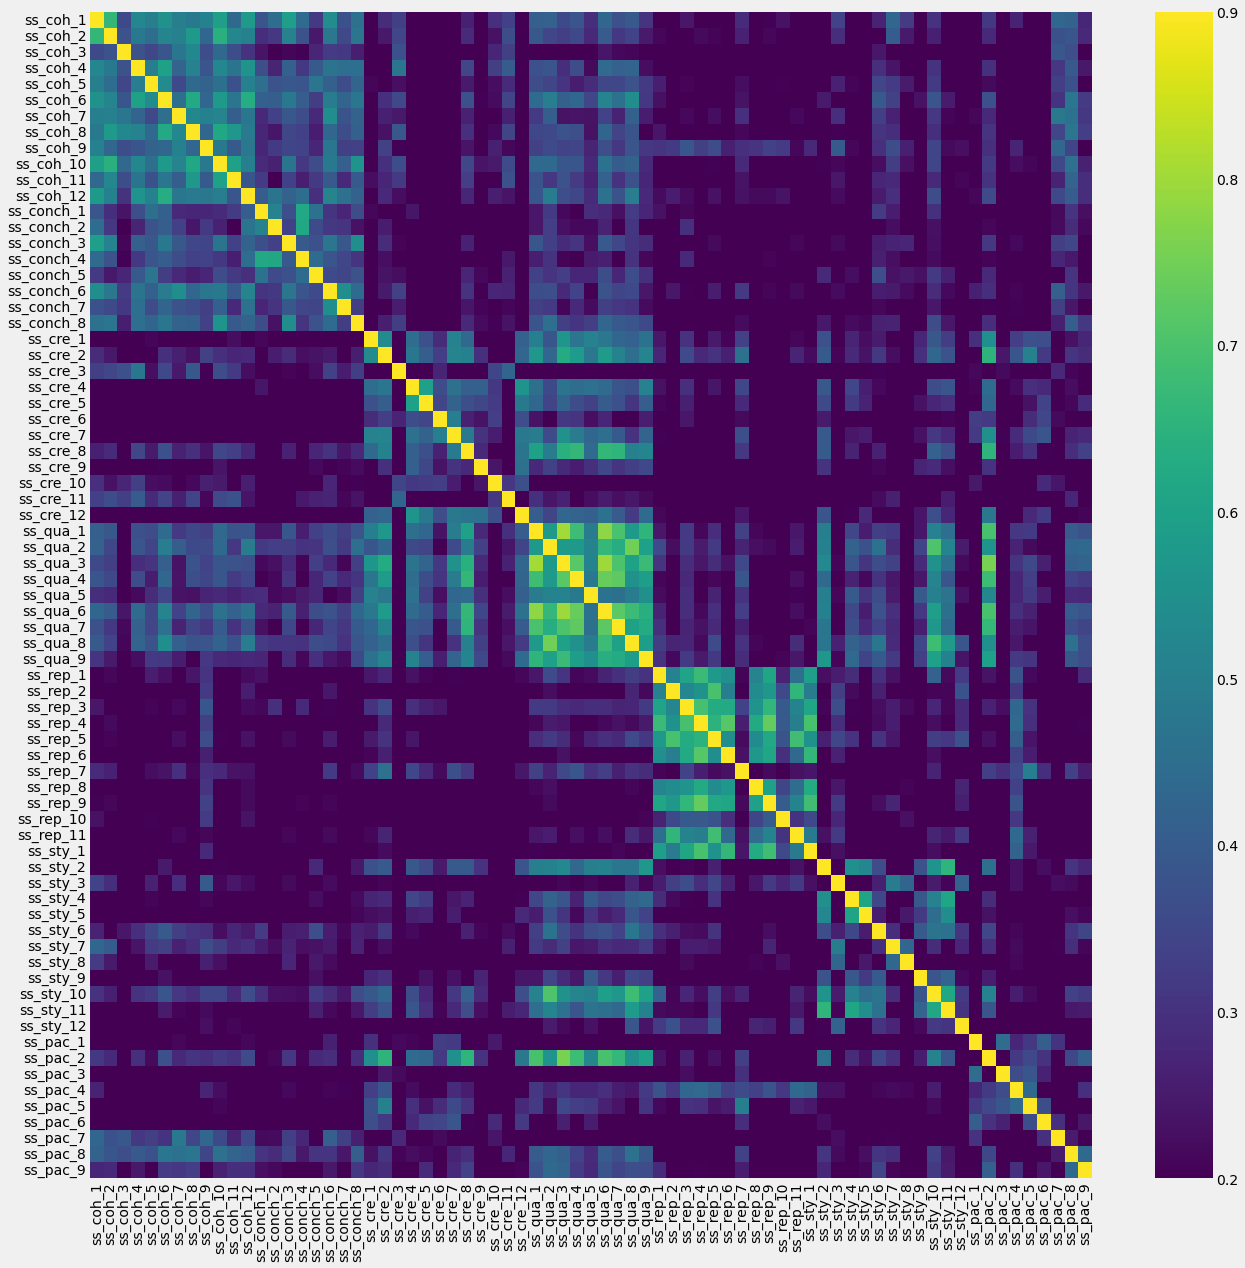

In [10]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.2, vmax=0.9)

# most item clusters are just surprising orthogonal (which is actually nice)


Most item clusters look fairly orthogonal (i.e. distinct). This would actually be quite nice for getting a simple structure in the EFA if this should hold true.


#### Investigate Multicollinearity

I will be using the determinant of the correlation matrix to check for multicollinearity. A determinant < .00001 is usually seen as a sign for a a high degree of multicollinearity ([Tabachnick & Fidell, 2018](https://www.pearson.com/en-us/subject-catalog/p/using-multivariate-statistics/P200000003097)).


In [11]:
print(f"Determinant of correlation matrix: {np.linalg.det(items_corr)}")


Determinant of correlation matrix: 3.527892546213652e-23


The determinant is far below .00001. This indicates not only a high degree of multicollinearity, but also a fair amount of redundancy among the items. Using the variance inflation factor (VIF) I will check for the individual items that are most problematic. In an iterative process, I will drop the items with the highest VIF from analysis until the determinant is above .00001.


In [12]:
# Apply function to obtain reduced list of items without multicollinearity for analysis
items_analysis = efa_utils.reduce_multicoll(
    aiss, item_labels, vars_descr=items_descr, print_details=True)


Beginning check for multicollinearity

Determinant of initial correlation matrix: 3.527892546213652e-23

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item ss_qua_3. VIF: 39.81
('The story was fun to read.')

Excluded item ss_coh_12. VIF: 31.08
('The story lacked logic.')

Excluded item ss_qua_6. VIF: 29.05
('I liked this story.')

Excluded item ss_coh_1. VIF: 26.94
('I had a hard time making sense of what was going on in the story.')

Excluded item ss_qua_1. VIF: 24.45
('This story was enjoyable.')

Excluded item ss_rep_4. VIF: 23.64
('In the story, the same things happened again and again.')

Excluded item ss_qua_8. VIF: 23.57
('The story was well-written.')

Excluded item ss_cre_4. VIF: 23.31
('The story was creative.')

Excluded item ss_sty_4. VIF: 22.65
('The text contained a broad vocabulary.')

Excluded item ss_conch_5. VIF: 22.20
('The descriptions of characters in the story were plausible.')

Excluded item ss_cre_2. VIF: 22.02
('The

#### Check Sampling Adequacy (KMO)

Kaiser–Meyer–Olkin (KMO) measure of sampling adequacy is a measure of how well the data set can be described by a factor analysis model. It is a measure of the proportion of variance in the variables that is explained by the factors ([Kaiser & Rice, 1974](https://journals.sagepub.com/doi/10.1177/001316447403400115)). A high KMO indicates that correlation patterns are relatively compact and that the factors are well defined. A value of .6 is usually seen as a good threshold ([Tabachnik & Fidell, 2018](https://www.pearson.com/en-us/subject-catalog/p/using-multivariate-statistics/P200000003097)).

| KMO  | Interpretation ([Kaiser & Rice, 1974](https://journals.sagepub.com/doi/10.1177/001316447403400115)) |
| ---- | --------------------------------------------------------------------------------------------------- |
| > .9 | Marvellous                                                                                          |
| > .8 | Meritorious                                                                                         |
| > .7 | Middling                                                                                            |
| > .6 | Mediocre                                                                                            |
| < .6 | Unacceptable                                                                                        |

Why did Kaiser & Rice ruin the pattern by not chosing a word starting with "M" for the last category? We'll never know...


In [14]:
# Check KMO
efa_utils.kmo_check(aiss, items_analysis, dropna_thre=0, check_item_kmos=True, return_kmos=False)


Overall KMO: 0.8613594159011393
All item KMOs are >.6


The KMO is .86. This is a very good value, indicating that the data is well suited for factor analysis.


## Running the EFA


### Determine the Number of Factors
As a first step, I will determine the optimal number of factors for explaining the variance in the responses to the items. I will be using the screeplot as well as a parallel analysis to determine the ideal number of factors ([Zwick & Velicer, 1986](https://www.researchgate.net/profile/Wayne-Velicer/publication/225083592_Comparison_of_5_rules_for_determining_the_number_of_components_to_retain/links/00b49518930d4067e4000000/Comparison-of-5-rules-for-determining-the-number-of-components-to-retain.pdf)).

If the methods disagree on the number of factors (or if the results are ambigous), I will examine all solutions and choose the one that seems most reasonable (which solution seems most clean & interpretable).

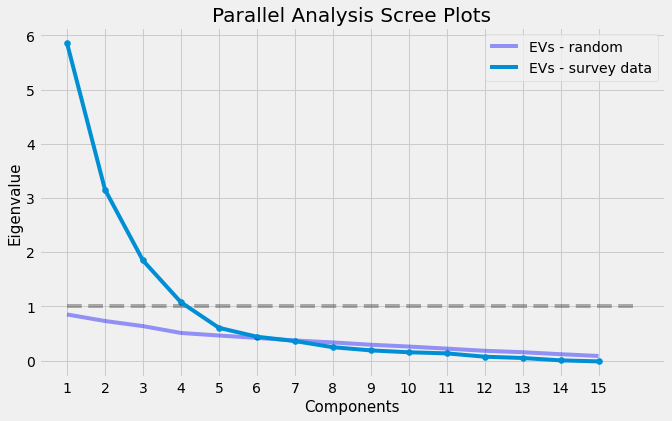

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.85				5.85
2	0.73				3.15
3	0.64				1.85
4	0.51				1.08
5	0.46				0.60
6	0.42				0.44
7	0.37				0.36
8	0.34				0.25
9	0.29				0.19
10	0.26				0.15
11	0.22				0.13
12	0.18				0.07
13	0.15				0.05
14	0.12				0.00
15	0.09				-0.02
Suggested number of factors based on parallel analysis: 6


In [15]:
efa_utils.parallel_analysis(aiss, items_analysis, return_rec_n=False)


### 6 factor solution


In [18]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=6, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique



Factor Correlation Matrix (Oblique Rotation):
[[ 1.         -0.06624568 -0.24057842 -0.08011395 -0.42619419  0.27108044]
 [-0.06624568  1.         -0.12501958  0.05569953  0.00819579  0.2901127 ]
 [-0.24057842 -0.12501958  1.          0.19156907  0.28938682 -0.24868845]
 [-0.08011395  0.05569953  0.19156907  1.          0.10661497  0.23610441]
 [-0.42619419  0.00819579  0.28938682  0.10661497  1.         -0.25579226]
 [ 0.27108044  0.2901127  -0.24868845  0.23610441 -0.25579226  1.        ]]


Fitted solution #1



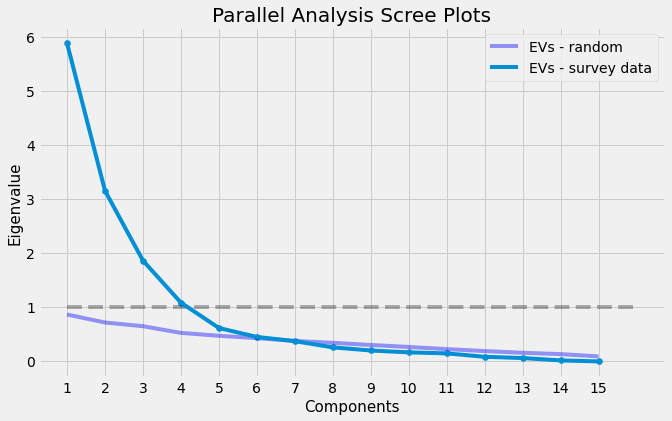

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.85				5.88
2	0.71				3.15
3	0.64				1.85
4	0.51				1.07
5	0.46				0.60
6	0.42				0.44
7	0.36				0.36
8	0.33				0.24
9	0.29				0.19
10	0.25				0.15
11	0.21				0.13
12	0.18				0.07
13	0.14				0.05
14	0.12				0.00
15	0.08				-0.02
Suggested number of factors based on parallel analysis: 6

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_sty_9: The story contained a great deal of detail.
Communality: 0.1988

Fitted solution #2



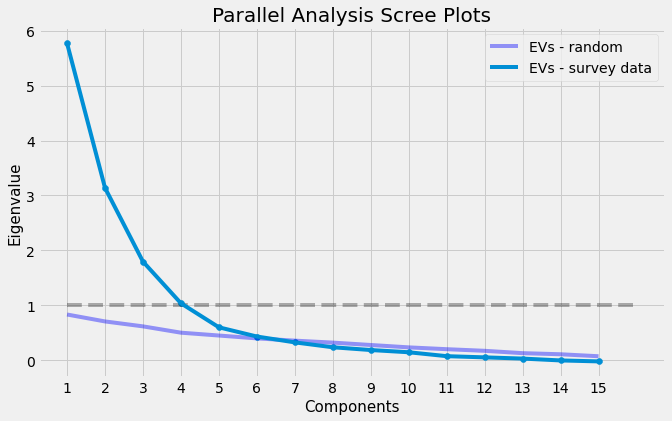

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.83				5.77
2	0.71				3.14
3	0.62				1.80
4	0.50				1.04
5	0.45				0.60
6	0.40				0.43
7	0.36				0.33
8	0.32				0.24
9	0.28				0.19
10	0.23				0.15
11	0.20				0.07
12	0.17				0.05
13	0.13				0.03
14	0.11				-0.00
15	0.07				-0.02
Suggested number of factors based on parallel analysis: 6

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 5 items with low main loading. Excluding them for next analysis.

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Main (absolute) Loading: 0.3453

Removed item tss_conch_7: How characters in the story acted seemed implausible.
Main (absolute) Loading: 0.2811

Removed item tss_sty_3: The story had sentences that were unreadable
Main (absolute) Loading: 0.3963

Removed item tss_sty_5: The story used complex vocabulary.

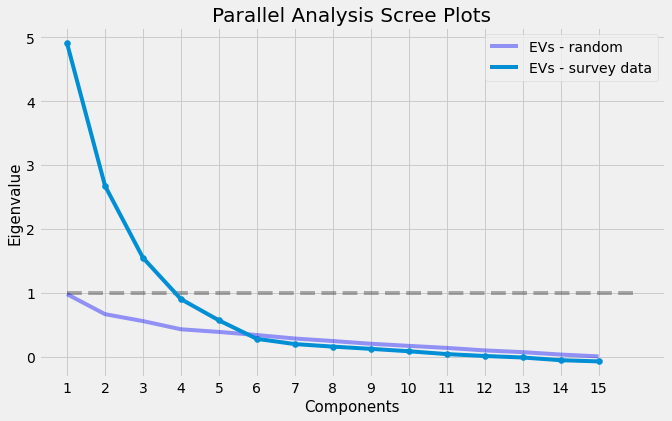

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.98				4.91
2	0.67				2.68
3	0.56				1.55
4	0.43				0.90
5	0.39				0.57
6	0.34				0.28
7	0.28				0.20
8	0.25				0.16
9	0.20				0.12
10	0.17				0.09
11	0.14				0.04
12	0.10				0.01
13	0.07				-0.01
14	0.03				-0.05
15	0.00				-0.07
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 3 items with low main loading. Excluding them for next analysis.

Removed item tss_qua_2: This story is of high quality.
Main (absolute) Loading: 0.3905

Removed item tss_sty_8: The writing style was too complicated to be understood easily.
Main (absolute) Loading: 0.2948

Removed item tss_pac_6: There was plenty of action in the story.
Main (absolute) Loading: 0.3575

Fitted solution #4



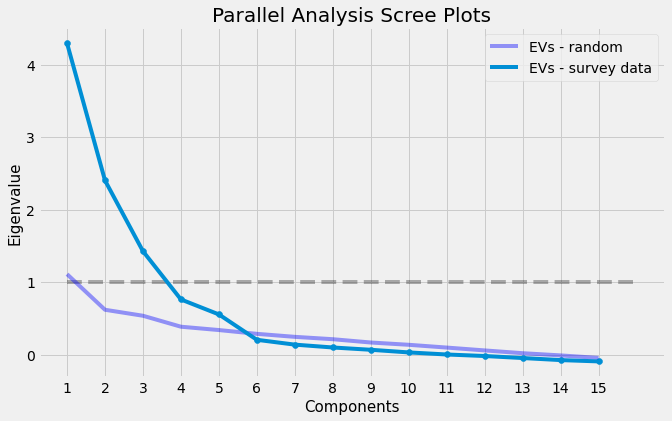

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.11				4.30
2	0.62				2.40
3	0.54				1.43
4	0.38				0.76
5	0.34				0.55
6	0.29				0.20
7	0.24				0.14
8	0.21				0.10
9	0.17				0.07
10	0.13				0.03
11	0.10				0.00
12	0.06				-0.02
13	0.02				-0.05
14	-0.01				-0.08
15	-0.05				-0.09
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 3 items with high cross loading. Excluding them for next analysis.

Removed item tss_qua_7: I would like to read more stories like this one.
Loadings: 
0    0.425276
1    0.453287
2   -0.130480
3    0.050120
4    0.024164
5    0.013087
Name: tss_qua_7, dtype: float64

Removed item tss_pac_1: The story moved at a fast pace.
Loadings: 
0   -0.144367
1    0.079665
2   -0.034555
3    0.10595

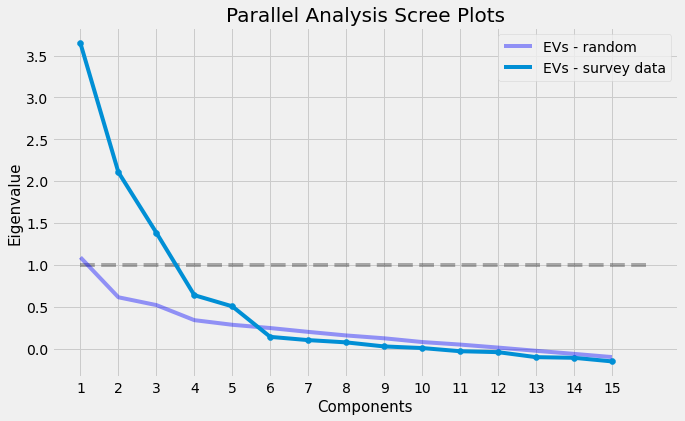

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.09				3.65
2	0.61				2.11
3	0.52				1.38
4	0.34				0.64
5	0.28				0.50
6	0.25				0.14
7	0.20				0.10
8	0.16				0.07
9	0.12				0.03
10	0.08				0.01
11	0.05				-0.03
12	0.01				-0.04
13	-0.03				-0.10
14	-0.06				-0.11
15	-0.10				-0.15
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_rep_11: Characters repeated what other characters had said to them.
Main (absolute) Loading: 0.3890

Fitted solution #6



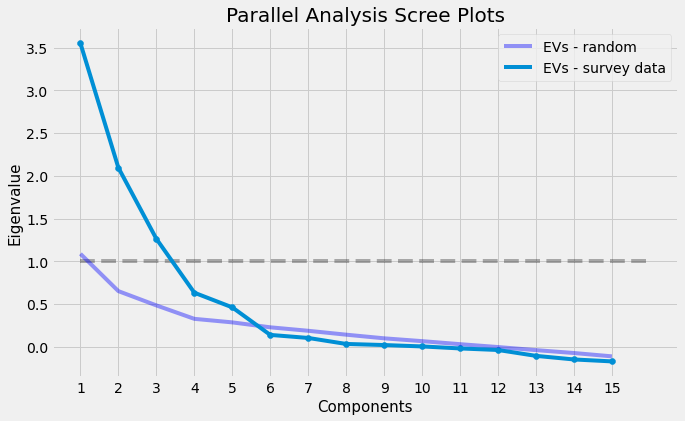

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.09				3.55
2	0.65				2.10
3	0.48				1.26
4	0.33				0.63
5	0.28				0.46
6	0.23				0.14
7	0.19				0.10
8	0.14				0.03
9	0.10				0.02
10	0.06				0.00
11	0.03				-0.02
12	-0.01				-0.04
13	-0.04				-0.11
14	-0.08				-0.15
15	-0.11				-0.17
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 1 items with high cross loading. Excluding them for next analysis.

Removed item tss_cre_12: The story was innovative.
Loadings: 
0   -0.026253
1   -0.031253
2   -0.064889
3    0.404228
4   -0.015658
5    0.358846
Name: tss_cre_12, dtype: float64

Fitted solution #7



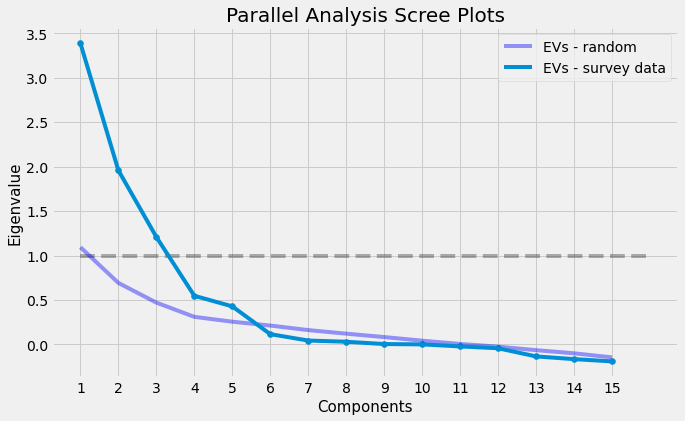

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.09				3.39
2	0.69				1.96
3	0.47				1.21
4	0.31				0.55
5	0.26				0.43
6	0.21				0.12
7	0.16				0.04
8	0.12				0.03
9	0.08				0.01
10	0.04				0.00
11	0.01				-0.02
12	-0.02				-0.04
13	-0.06				-0.13
14	-0.10				-0.16
15	-0.14				-0.19
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.00825916981605751
Determinant looks good!
Overall KMO: 0.7938871117655758
All item KMOs are >.6


In [20]:
six_facs = iterative_efa(tss_df, items_analysis_li, n_facs=6, rotation_method="Oblimin", print_details=True,
                         print_par_plot=True, print_par_table=True, auto_stop_par=False)

In [21]:
efa_6 = six_facs[0]
items_6 = six_facs[1]

print_sorted_loadings(efa_6, items_6, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                    0                                                                     descr
tss_pac_8    0.663654                      All elements of the story were relevant to the plot.
tss_coh_6    0.634834                                     The story felt like a coherent story.
tss_coh_11   0.616027                                              The story had a clear theme.
tss_coh_3    0.575818                                   The story appeared to be a single plot.
tss_conch_8  0.485254  It was easy to understand the motivation of the characters in the story. 

Relevant loadings for factor 1
                  1                                                                             descr
tss_rep_9  0.752388  One character did something he or she had already done previously in this story.
tss_rep_3  0.732397            Many sentences in the story had frequently repeated words and phrases.
tss_rep_2 -0.668666                                   

In [22]:
items_per_fac_6 = rev_items_and_return(tss_df, efa_6, items_6)

for factor_n in items_per_fac_6:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_6[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...


Internal consistency for factor 0:
Cronbachs alpha = 0.7699, 95% CI = [0.73, 0.81]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.7583
tss_coh_6: 0.6978
tss_coh_11: 0.7208
tss_conch_8: 0.7375
tss_pac_8: 0.7223


Internal consistency for factor 1:
Cronbachs alpha = 0.7629, 95% CI = [0.71, 0.80]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.6778
tss_rep_9: 0.6735
tss_rep_2_rev: 0.6940


Internal consistency for factor 2:
Internal consistency for factor 3:
Cronbachs alpha = 0.6144, 95% CI = [0.54, 0.68]

Cronbach's alpha when excluding variable...
tss_cre_6: 0.4661
tss_cre_7: 0.3849
tss_cre_9: 0.6646


Internal consistency for factor 4:
Cronbachs alpha = 0.6617, 95% CI = [0.59, 0.72]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.5582
tss_pac_3: 0.6646
tss_pac_5: 0.4578


Internal consistency for factor 5:


In [23]:
items_6_2 = copy.deepcopy(items_6)

items_6_2.remove("tss_cre_9")
items_6_2.remove("tss_pac_3")

items_6_2.extend(["tss_coh_4", "tss_coh_5",
                  "tss_conch_1", "tss_conch_3",
                  "tss_conch_5", "tss_conch_6"])
items_6_2.extend(["tss_cre_1", "tss_cre_4", "tss_cre_2",
                  "tss_cre_10", "tss_cre_5", "tss_cre_8",
                  "tss_cre_11"])
items_6_2.extend(["tss_pac_2", "tss_pac_4"])
items_6_2.extend(["tss_coh_12", "tss_coh_1",
                  "tss_qua_4", "tss_qua_5"])


In [24]:
items_6_2 = reduce_multicoll(
    tss_df, items_6_2, vars_descr=items_descr, print_details=True)


Beginning check for multicollinearity

Determinant of initial correlation matrix: 5.3895840309819185e-08

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_coh_12. VIF: 25.16
('The story lacked logic.')

Excluded item tss_coh_1. VIF: 19.09
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_cre_2. VIF: 18.46
('The story was boring.')

Excluded item tss_cre_5. VIF: 18.11
('The story was imaginative.')

Excluded item tss_conch_5. VIF: 17.16
('The descriptions of characters in the story were plausible.')

Excluded item tss_pac_2. VIF: 16.34
('The story was exciting to read.')

Excluded item tss_conch_1. VIF: 16.26
('Descriptions of characters in the story were consistent.')

Done! Determinant is now: 0.000018
I have excluded 7 redunant items with 27 items remaining


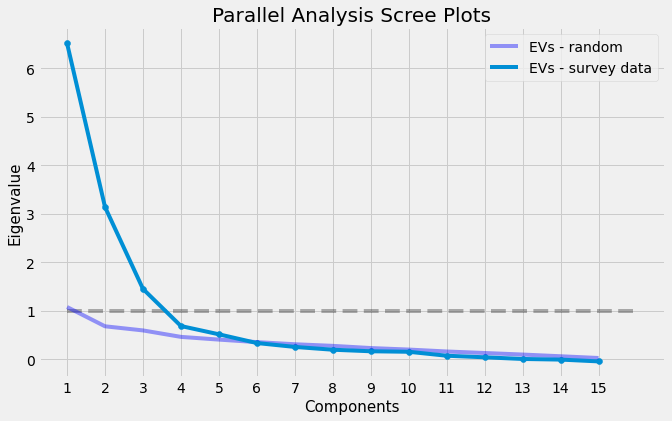

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.08				6.52
2	0.68				3.14
3	0.60				1.45
4	0.46				0.69
5	0.41				0.51
6	0.35				0.33
7	0.31				0.25
8	0.28				0.20
9	0.23				0.17
10	0.20				0.15
11	0.16				0.07
12	0.13				0.04
13	0.10				0.01
14	0.06				-0.01
15	0.03				-0.04
Suggested number of factors based on parallel analysis: 5


5

In [25]:
parallel_analysis(tss_df, items_6_2)


In [26]:
six_facs_2 = iterative_efa(tss_df, items_6_2, n_facs=6, rotation_method="Oblimin", print_details=False,
                           print_par_plot=False, auto_stop_par=False)


Fitted solution #1


Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 3 items with low main loading. Excluding them for next analysis.

Fitted solution #2


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 3 items with high cross loading. Excluding them for next analysis.

Fitted solution #3


Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Fitted solution #4


Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Fitted solution #5


Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Fitted solution #6


Checking for low communalities
All communalities 

In [27]:
efa_6_2 = six_facs_2[0]
items_6_2 = six_facs_2[1]

print_sorted_loadings(efa_6_2, items_6_2, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                  0                                    descr
tss_qua_4  0.817192  The story made me want to keep reading.
tss_cre_8  0.797427             I was intrigued by the plot. 

Relevant loadings for factor 1
                    1                                                              descr
tss_conch_2  0.805609  Characters in the story were described in a contradicting manner.
tss_conch_4  0.788489            The way the characters were described was inconsistent. 

Relevant loadings for factor 2
                  2                                                                             descr
tss_rep_2  0.739214                                                    This story avoided repetition.
tss_rep_9 -0.720175  One character did something he or she had already done previously in this story. 

Relevant loadings for factor 3
                  3                    descr
tss_cre_4  0.502496  The story was creative. 

Relevant loadings for 

### 5 Factor Solution


In [28]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=5, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)



Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.04140453 -0.26250934  0.16630698 -0.44928045]
 [ 0.04140453  1.          0.16522727 -0.24830006  0.05674742]
 [-0.26250934  0.16522727  1.         -0.08336328  0.30109338]
 [ 0.16630698 -0.24830006 -0.08336328  1.         -0.19698446]
 [-0.44928045  0.05674742  0.30109338 -0.19698446  1.        ]]


Fitted solution #1



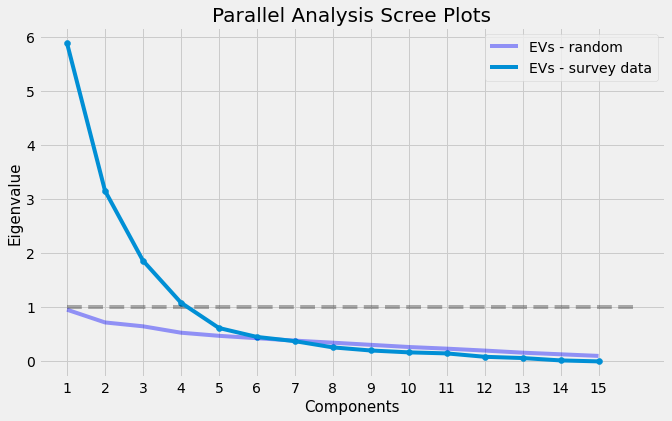

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.94				5.88
2	0.71				3.15
3	0.63				1.85
4	0.52				1.07
5	0.46				0.60
6	0.41				0.44
7	0.37				0.36
8	0.33				0.24
9	0.29				0.19
10	0.25				0.15
11	0.22				0.13
12	0.19				0.07
13	0.15				0.05
14	0.12				0.00
15	0.09				-0.02
Suggested number of factors based on parallel analysis: 6

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 4 items with low main loading. Excluding them for next analysis.

Removed item tss_conch_7: How characters in the story acted seemed implausible.
Main (absolute) Loading: 0.3381

Removed item tss_cre_6: It was surprising how things turned out in the story.
Main (absolute) Loading: 0.3842

Removed item tss_sty_3: The story had sentences that were unreadable
Main (absolute) Loading: 0.3488

Removed item tss_pac_9: There's nothing superfluous or unnece

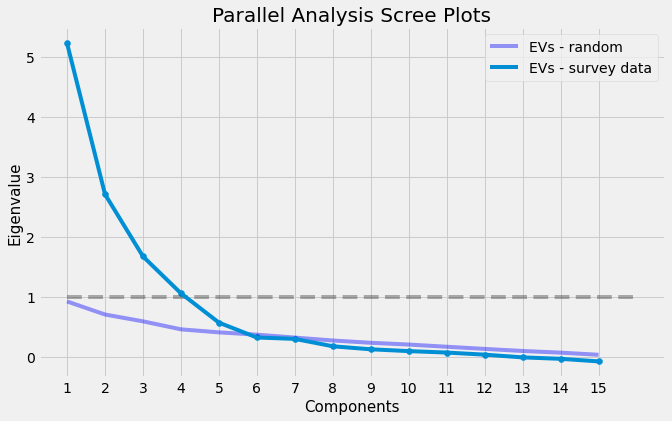

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.92				5.22
2	0.70				2.71
3	0.59				1.67
4	0.46				1.06
5	0.41				0.57
6	0.37				0.32
7	0.32				0.30
8	0.27				0.17
9	0.23				0.12
10	0.20				0.09
11	0.17				0.07
12	0.13				0.03
13	0.09				-0.01
14	0.07				-0.04
15	0.03				-0.08
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_sty_8: The writing style was too complicated to be understood easily.
Main (absolute) Loading: 0.3673

Fitted solution #3



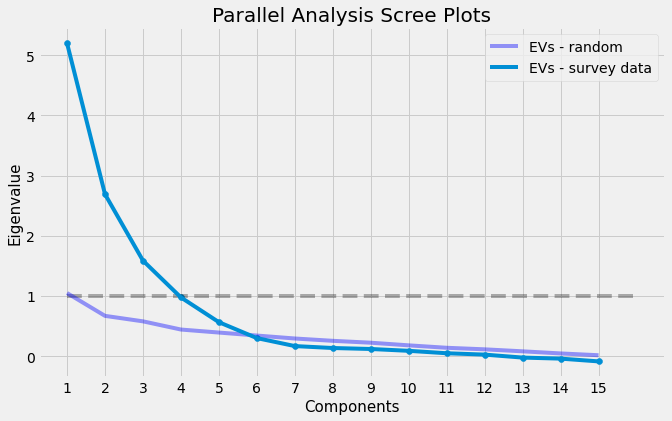

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.05				5.20
2	0.67				2.69
3	0.58				1.59
4	0.45				0.98
5	0.40				0.57
6	0.35				0.30
7	0.30				0.17
8	0.26				0.14
9	0.23				0.12
10	0.18				0.09
11	0.14				0.05
12	0.12				0.03
13	0.08				-0.02
14	0.05				-0.04
15	0.02				-0.08
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 4 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0   -0.499110
1    0.073714
2    0.134000
3    0.317299
4    0.154937
Name: tss_coh_9, dtype: float64

Removed item tss_conch_8: It was easy to understand the motivation of the characters in the story.
Loadings: 
0    0.456776
1    0.

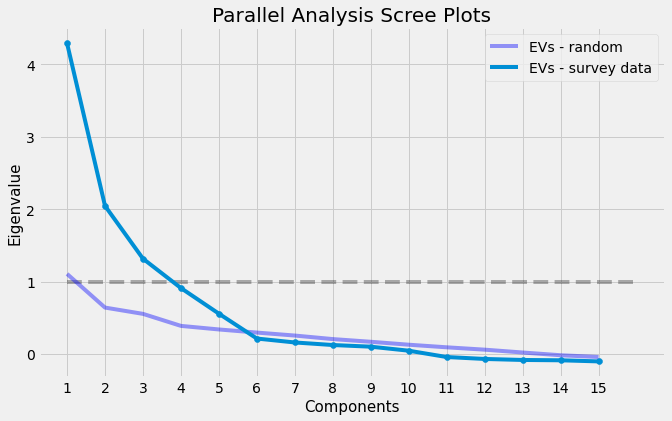

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.11				4.29
2	0.64				2.05
3	0.55				1.32
4	0.39				0.91
5	0.34				0.56
6	0.29				0.21
7	0.25				0.16
8	0.20				0.12
9	0.17				0.10
10	0.13				0.04
11	0.09				-0.04
12	0.06				-0.07
13	0.02				-0.08
14	-0.02				-0.09
15	-0.04				-0.10
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.001273236895406989
Determinant looks good!
Overall KMO: 0.8181735598816975
All item KMOs are >.6


In [29]:
five_facs = iterative_efa(tss_df, items_analysis_li, n_facs=5, rotation_method="Oblimin", print_details=True,
                          print_par_plot=True, print_par_table=True, auto_stop_par=True)


In [30]:
efa_5 = five_facs[0]
items_5 = five_facs[1]

print_sorted_loadings(efa_5, items_5, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                   0                                             descr
tss_cre_12  0.654268                         The story was innovative.
tss_qua_2   0.622362                    This story is of high quality.
tss_qua_7   0.592528  I would like to read more stories like this one.
tss_cre_9   0.553331            The setting of the story was original.
tss_sty_5   0.501835                The story used complex vocabulary.
tss_sty_9   0.478183       The story contained a great deal of detail. 

Relevant loadings for factor 1
                   1                                                     descr
tss_coh_3   0.633580                   The story appeared to be a single plot.
tss_coh_11  0.591978                              The story had a clear theme.
tss_cre_3   0.579782        The plot development in the story was predictable.
tss_pac_8   0.533217      All elements of the story were relevant to the plot.
tss_coh_6   0.489955                     The

In [31]:
items_per_fac_5 = rev_items_and_return(tss_df, efa_5, items_5)

for factor_n in items_per_fac_5:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_5[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...


Internal consistency for factor 0:
Cronbachs alpha = 0.7538, 95% CI = [0.71, 0.79]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.7302
tss_cre_12: 0.7138
tss_qua_2: 0.6831
tss_qua_7: 0.6989
tss_sty_5: 0.7377
tss_sty_9: 0.7411


Internal consistency for factor 1:
Cronbachs alpha = 0.7629, 95% CI = [0.72, 0.80]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.7162
tss_coh_6: 0.7058
tss_coh_11: 0.7192
tss_cre_3: 0.7454
tss_pac_8: 0.7303
tss_pac_7_rev: 0.7494


Internal consistency for factor 2:
Cronbachs alpha = 0.7447, 95% CI = [0.70, 0.79]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.6450
tss_rep_9: 0.6459
tss_rep_11: 0.7629
tss_rep_2_rev: 0.6768


Internal consistency for factor 3:
Cronbachs alpha = 0.6859, 95% CI = [0.63, 0.74]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6473
tss_pac_3: 0.5962
tss_pac_5: 0.5720
tss_pac_1_rev: 0.6617


Internal consistency for factor 4:


In [32]:
items_5_2 = copy.deepcopy(items_5)

items_5_2.remove("tss_rep_11")

# items_5_2.extend(["tss_rep_4", "tss_rep_5",
#                   "tss_rep_6", "tss_rep_7", "tss_rep_10", "tss_rep_12"])
# items_5_2.extend(["tss_cre_1", "tss_cre_2", "tss_cre_4",
#                  "tss_cre_5", "tss_cre_8", "tss_cre_10", "tss_cre_11"])
items_5_2.extend(["tss_pac_2", "tss_pac_4"])
#items_5_2.extend(["tss_sty_1", "tss_sty_2", "tss_sty_4", "tss_sty_11"])
items_5_2.extend(["tss_coh_1", "tss_coh_4", "tss_coh_5", "tss_coh_12",
                  "tss_conch_1", "tss_conch_3",
                  "tss_conch_5", "tss_conch_6"])


In [33]:
items_5_2 = reduce_multicoll(
    tss_df, items_5_2, vars_descr=items_descr, print_details=True)


Beginning check for multicollinearity

Determinant of initial correlation matrix: 1.4887694671821372e-06

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_coh_12. VIF: 23.99
('The story lacked logic.')

Excluded item tss_coh_1. VIF: 19.43
('I had a hard time making sense of what was going on in the story.')

Done! Determinant is now: 0.000010
I have excluded 2 redunant items with 29 items remaining


Fitted solution #1



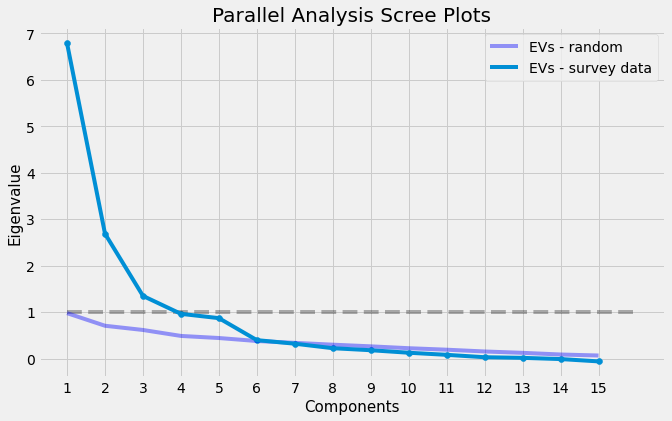


Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_conch_3: My understanding of the characters in the story is unclear.
Main (absolute) Loading: 0.3912

Fitted solution #2



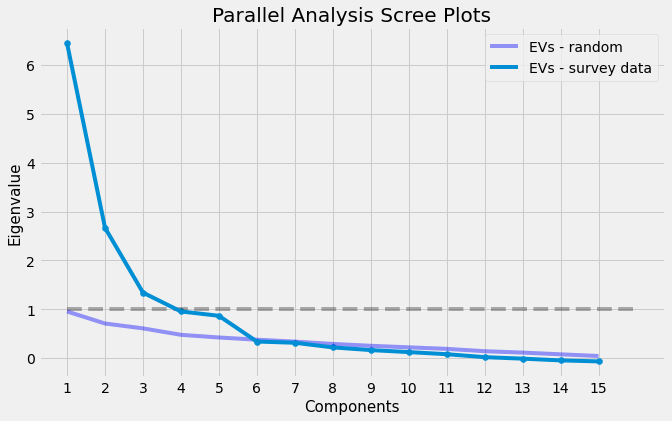


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 2 items with high cross loading. Excluding them for next analysis.

Removed item tss_pac_4: The story dragged on and on.
Loadings: 
0    0.003757
1   -0.025315
2   -0.107306
3    0.492305
4    0.320251
Name: tss_pac_4, dtype: float64

Removed item tss_coh_5: This story’s events occurred in a plausible order
Loadings: 
0    0.408107
1    0.049929
2    0.318905
3   -0.009629
4   -0.107411
Name: tss_coh_5, dtype: float64

Fitted solution #3



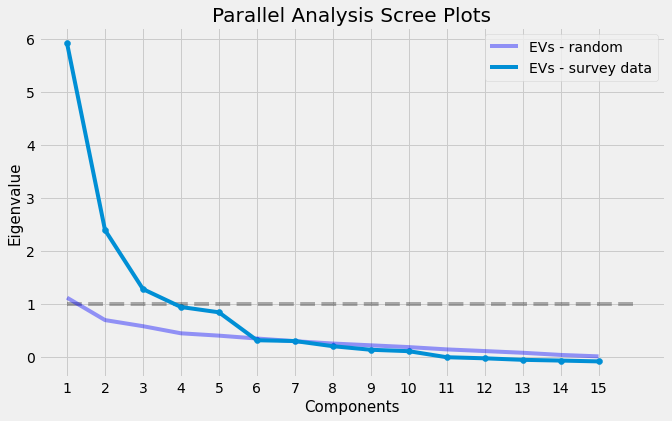


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 1 items with high cross loading. Excluding them for next analysis.

Removed item tss_conch_5: The descriptions of characters in the story were plausible.
Loadings: 
0    0.215499
1    0.136082
2   -0.414320
3   -0.045574
4    0.086628
Name: tss_conch_5, dtype: float64

Fitted solution #4



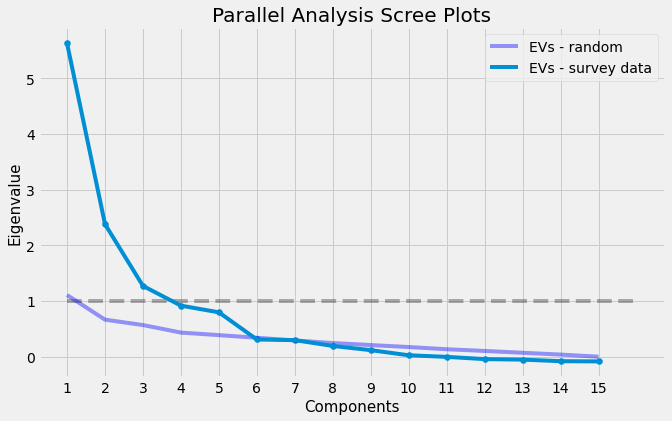


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 9.167162193291894e-05
Determinant looks good!
Overall KMO: 0.8587600163782054
All item KMOs are >.6


In [34]:
five_facs_2 = iterative_efa(tss_df, items_5_2, n_facs=5, rotation_method="Oblimin", print_details=True,
                            print_par_plot=True, auto_stop_par=True)


In [35]:
efa_5_2 = five_facs_2[0]
items_5_2 = five_facs_2[1]

print_sorted_loadings(efa_5_2, items_5_2, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                    0                                                              descr
tss_coh_4    0.635612                               The plot of the story was plausible.
tss_cre_3    0.634828                 The plot development in the story was predictable.
tss_coh_3    0.596288                            The story appeared to be a single plot.
tss_coh_11   0.581914                                       The story had a clear theme.
tss_conch_6 -0.532196  The behavior of characters in the story seemed completely random.
tss_coh_6    0.510121                              The story felt like a coherent story.
tss_pac_7   -0.488218           Many things seemed to be happening at once in the story.
tss_pac_8    0.477100               All elements of the story were relevant to the plot. 

Relevant loadings for factor 1
                   1                                             descr
tss_qua_7   0.671232  I would like to read more stories like thi

In [36]:
items_per_fac_5_2 = rev_items_and_return(tss_df, efa_5_2, items_5_2)

for factor_n in items_per_fac_5_2:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_5_2[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")


Internal consistency for factor 0:
Cronbachs alpha = 0.8295, 95% CI = [0.80, 0.86]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.8122
tss_coh_6: 0.7955
tss_coh_11: 0.8079
tss_cre_3: 0.8187
tss_pac_8: 0.8163
tss_coh_4: 0.7958
tss_pac_7_rev: 0.8226
tss_conch_6_rev: 0.8070


Internal consistency for factor 1:
Cronbachs alpha = 0.7984, 95% CI = [0.76, 0.83]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.7883
tss_cre_12: 0.7699
tss_qua_2: 0.7483
tss_qua_7: 0.7504
tss_sty_5: 0.7939
tss_sty_9: 0.7957
tss_pac_2: 0.7538


Internal consistency for factor 2:
Cronbachs alpha = 0.8079, 95% CI = [0.77, 0.84]

Cronbach's alpha when excluding variable...
tss_conch_2: 0.7639
tss_conch_4: 0.6763
tss_conch_1_rev: 0.7642


Internal consistency for factor 3:
Cronbachs alpha = 0.6859, 95% CI = [0.63, 0.74]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6473
tss_pac_3: 0.5962
tss_pac_5: 0.5720
tss_pac_1_rev: 0.6617


Internal consistency for factor 4:
Cronbachs alpha = 0.762

### 4 Factor Solution


In [37]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)



Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.01112745 -0.30209159  0.19596305]
 [ 0.01112745  1.          0.1707133  -0.24277865]
 [-0.30209159  0.1707133   1.         -0.08310535]
 [ 0.19596305 -0.24277865 -0.08310535  1.        ]]


Fitted solution #1



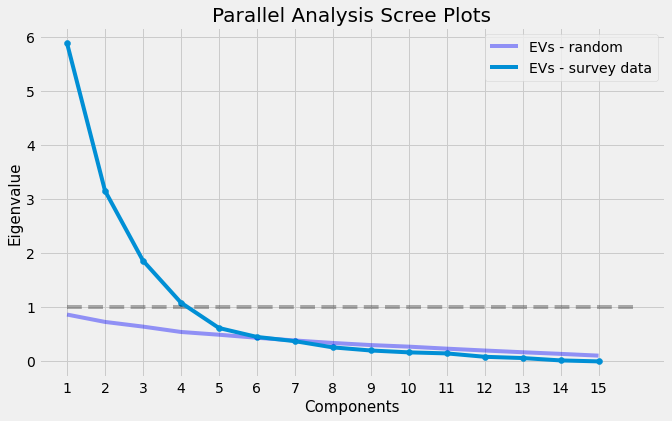

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.85				5.88
2	0.72				3.15
3	0.63				1.85
4	0.53				1.07
5	0.48				0.60
6	0.42				0.44
7	0.37				0.36
8	0.33				0.24
9	0.29				0.19
10	0.26				0.15
11	0.22				0.13
12	0.19				0.07
13	0.15				0.05
14	0.12				0.00
15	0.09				-0.02
Suggested number of factors based on parallel analysis: 6

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 2 items with low main loading. Excluding them for next analysis.

Removed item tss_sty_8: The writing style was too complicated to be understood easily.
Main (absolute) Loading: 0.3113

Removed item tss_pac_9: There's nothing superfluous or unnecessary in this story.
Main (absolute) Loading: 0.3320

Fitted solution #2



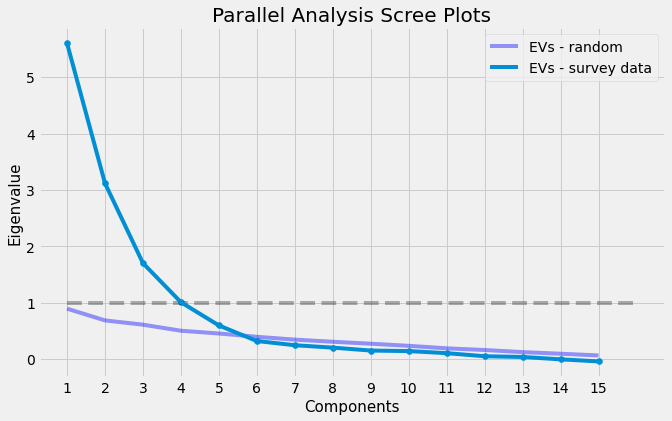

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.89				5.60
2	0.68				3.12
3	0.61				1.70
4	0.50				1.01
5	0.45				0.59
6	0.39				0.32
7	0.34				0.24
8	0.30				0.20
9	0.27				0.15
10	0.23				0.14
11	0.19				0.10
12	0.16				0.05
13	0.12				0.03
14	0.09				-0.01
15	0.06				-0.04
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_sty_3: The story had sentences that were unreadable
Main (absolute) Loading: 0.3879

Fitted solution #3



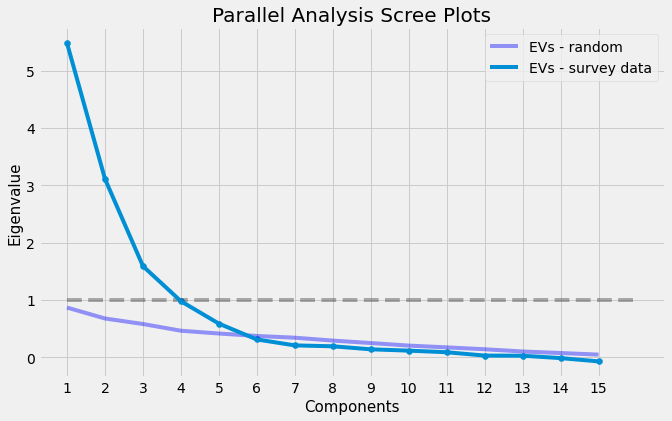

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.87				5.48
2	0.68				3.11
3	0.58				1.59
4	0.47				0.98
5	0.42				0.59
6	0.37				0.31
7	0.34				0.21
8	0.29				0.19
9	0.25				0.14
10	0.21				0.12
11	0.18				0.09
12	0.14				0.03
13	0.10				0.03
14	0.08				-0.01
15	0.05				-0.07
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 9 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_6: The story felt like a coherent story.
Loadings: 
0    0.683213
1    0.327888
2   -0.069708
3   -0.095192
Name: tss_coh_6, dtype: float64

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0   -0.596303
1   -0.035646
2   -0.109301
3    0.382590
Name: tss_coh_9, 

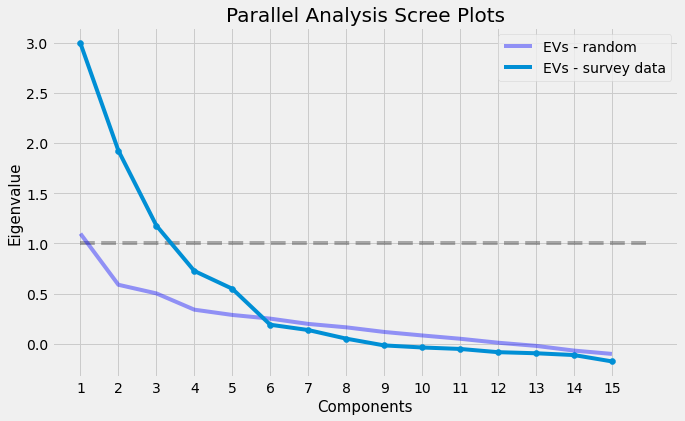

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.10				2.99
2	0.59				1.92
3	0.50				1.18
4	0.34				0.73
5	0.29				0.55
6	0.25				0.19
7	0.20				0.14
8	0.17				0.05
9	0.12				-0.01
10	0.08				-0.04
11	0.05				-0.05
12	0.01				-0.08
13	-0.02				-0.09
14	-0.07				-0.11
15	-0.10				-0.17
Suggested number of factors based on parallel analysis: 5

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.011346543619685843
Determinant looks good!
Overall KMO: 0.7683940173465315
All item KMOs are >.6


In [38]:
four_facs = iterative_efa(tss_df, items_analysis_li, n_facs=4, rotation_method="Varimax", print_details=True,
                          print_par_plot=True, print_par_table=True, auto_stop_par=True)


In [39]:
efa_4 = four_facs[0]
items_4 = four_facs[1]

print_sorted_loadings(efa_4, items_4, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                    0                                                              descr
tss_coh_3    0.620398                            The story appeared to be a single plot.
tss_pac_8    0.566546               All elements of the story were relevant to the plot.
tss_coh_11   0.565215                                       The story had a clear theme.
tss_pac_7   -0.562181           Many things seemed to be happening at once in the story.
tss_conch_7 -0.503200              How characters in the story acted seemed implausible.
tss_conch_4 -0.487431            The way the characters were described was inconsistent.
tss_cre_3    0.456055                 The plot development in the story was predictable.
tss_conch_2 -0.439144  Characters in the story were described in a contradicting manner. 

Relevant loadings for factor 1
                   1                                                                             descr
tss_rep_9   0.755274  One charac

In [40]:
items_per_fac_4 = rev_items_and_return(tss_df, efa_4, items_4)

for factor_n in items_per_fac_4:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...


Internal consistency for factor 0:
Cronbachs alpha = 0.7628, 95% CI = [0.72, 0.80]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.7289
tss_coh_11: 0.7335
tss_cre_3: 0.7526
tss_pac_8: 0.7372
tss_conch_2_rev: 0.7429
tss_conch_4_rev: 0.7342
tss_conch_7_rev: 0.7344
tss_pac_7_rev: 0.7374


Internal consistency for factor 1:
Cronbachs alpha = 0.7447, 95% CI = [0.70, 0.79]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.6450
tss_rep_9: 0.6459
tss_rep_11: 0.7629
tss_rep_2_rev: 0.6768


Internal consistency for factor 2:
Cronbachs alpha = 0.6249, 95% CI = [0.55, 0.69]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.5396
tss_cre_12: 0.5121
tss_sty_5: 0.5886
tss_sty_9: 0.5772


Internal consistency for factor 3:
Cronbachs alpha = 0.6473, 95% CI = [0.57, 0.71]

Cronbach's alpha when excluding variable...
tss_pac_3: 0.4737
tss_pac_5: 0.6137
tss_pac_1_rev: 0.5582




In [41]:
items_4_2 = copy.deepcopy(items_4)

items_4_2.remove("tss_rep_11")

items_4_2.extend(["tss_sty_4", "tss_sty_10", "tss_rep_1",
                  "tss_sty_11", "tss_sty_6", "tss_sty_2",
                  "tss_cre_1", "tss_cre_4", "tss_cre_2",
                  "tss_cre_10", "tss_cre_5", "tss_cre_8",
                  "tss_cre_11"])

items_4_2.extend(["tss_pac_2", "tss_pac_4"])


In [42]:
items_4_2 = reduce_multicoll(
    tss_df, items_4_2, vars_descr=items_descr, print_details=True)


Beginning check for multicollinearity

Determinant of initial correlation matrix: 5.937664809391925e-07

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_sty_11. VIF: 20.12
('The author's choice of words was elegant')

Excluded item tss_cre_4. VIF: 19.03
('The story was creative.')

Excluded item tss_sty_4. VIF: 17.54
('The text contained a broad vocabulary.')

Excluded item tss_sty_2. VIF: 16.60
('This story used interesting language.')

Done! Determinant is now: 0.000019
I have excluded 4 redunant items with 29 items remaining


In [43]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='oblimin')
efa.fit(tss_df[items_4_2])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)



Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.17905461 -0.27947473 -0.27311404]
 [ 0.17905461  1.         -0.19303084  0.06541536]
 [-0.27947473 -0.19303084  1.          0.1716917 ]
 [-0.27311404  0.06541536  0.1716917   1.        ]]


Fitted solution #1



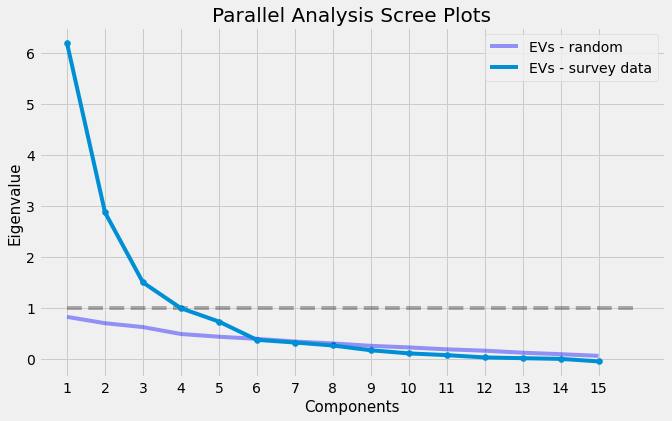


Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_conch_2: Characters in the story were described in a contradicting manner.
Main (absolute) Loading: 0.3606

Fitted solution #2



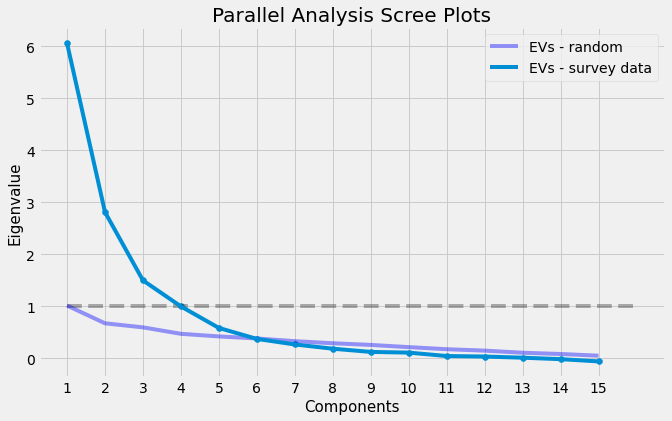


Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_conch_4: The way the characters were described was inconsistent.
Main (absolute) Loading: 0.3560

Fitted solution #3



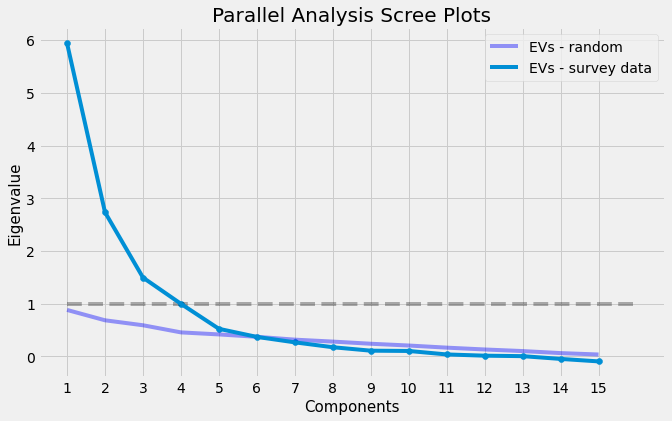


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 7 items with high cross loading. Excluding them for next analysis.

Removed item tss_pac_8: All elements of the story were relevant to the plot.
Loadings: 
0    0.301262
1    0.491975
2    0.213810
3    0.004961
Name: tss_pac_8, dtype: float64

Removed item tss_sty_6: The wording of this text was very precise.
Loadings: 
0    0.425994
1    0.331657
2   -0.002904
3   -0.255035
Name: tss_sty_6, dtype: float64

Removed item tss_cre_1: The story felt dynamic.
Loadings: 
0    0.530400
1    0.015382
2    0.415697
3   -0.086891
Name: tss_cre_1, dtype: float64

Removed item tss_cre_2: The story was boring.
Loadings: 
0   -0.579523
1   -0.123591
2   -0.472361
3    0.122239
Name: tss_cre_2, dtype: float64

Removed item tss_cre_10: The story was unconventional.
Loadings: 
0    0.306797
1   -0.528451
2    0.068141
3    0.094967
Name: tss_cre_

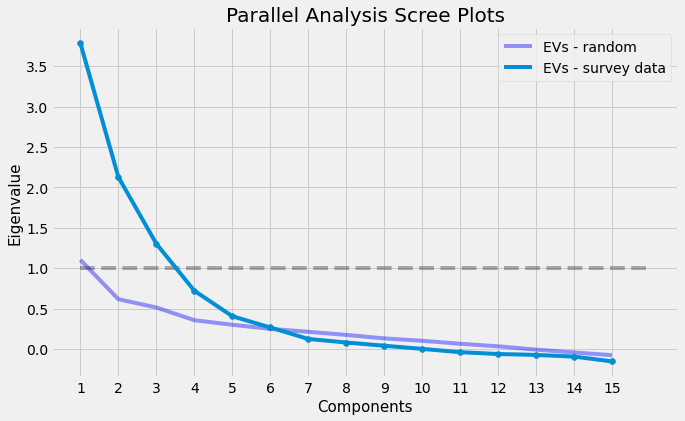


Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0033644803223221104
Determinant looks good!
Overall KMO: 0.8101178976417877
All item KMOs are >.6


In [44]:
four_facs_2 = iterative_efa(tss_df, items_4_2, n_facs=4, rotation_method="Varimax", print_details=True,
                            print_par_plot=True, auto_stop_par=True)


In [45]:
efa_4_2 = five_facs_2[0]
items_4_2 = five_facs_2[1]

print_sorted_loadings(efa_4_2, items_4_2, load_thresh=0.4, descr=items_descr)


Relevant loadings for factor 0
                    0                                                              descr
tss_coh_4    0.635612                               The plot of the story was plausible.
tss_cre_3    0.634828                 The plot development in the story was predictable.
tss_coh_3    0.596288                            The story appeared to be a single plot.
tss_coh_11   0.581914                                       The story had a clear theme.
tss_conch_6 -0.532196  The behavior of characters in the story seemed completely random.
tss_coh_6    0.510121                              The story felt like a coherent story.
tss_pac_7   -0.488218           Many things seemed to be happening at once in the story.
tss_pac_8    0.477100               All elements of the story were relevant to the plot. 

Relevant loadings for factor 1
                   1                                             descr
tss_qua_7   0.671232  I would like to read more stories like thi

# Examine Scale Scores


In [46]:
# items_per_fac_4_2[1].remove("tss_rep_11")
# items_per_fac_4_2[2].remove("tss_cre_9")
items_per_fac_5_2


{0: ['tss_coh_3',
  'tss_coh_6',
  'tss_coh_11',
  'tss_cre_3',
  'tss_pac_8',
  'tss_coh_4',
  'tss_pac_7_rev',
  'tss_conch_6_rev'],
 1: ['tss_cre_9',
  'tss_cre_12',
  'tss_qua_2',
  'tss_qua_7',
  'tss_sty_5',
  'tss_sty_9',
  'tss_pac_2'],
 2: ['tss_conch_2', 'tss_conch_4', 'tss_conch_1_rev'],
 3: ['tss_rep_8', 'tss_pac_3', 'tss_pac_5', 'tss_pac_1_rev'],
 4: ['tss_rep_3', 'tss_rep_9', 'tss_rep_2_rev']}

In [47]:
# The following code could be used to get mean scale scores
# Gave preference to factor scores instead (see below)

# # compute scale means but only if at least 66% of questions are answered
# mask_suff_data_coh = tss_df[items_per_fac_5_2[0]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[0])/3)
# mask_suff_data_cre = tss_df[items_per_fac_5_2[1]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[1])/3)
# mask_suff_data_conch = tss_df[items_per_fac_5_2[2]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[2])/3)
# mask_suff_data_pac = tss_df[items_per_fac_5_2[3]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[3])/3)
# mask_suff_data_rep = tss_df[items_per_fac_5_2[4]].isna().sum(
#     axis=1) <= round(len(items_per_fac_5_2[4])/3)

# tss_df["tss_coh"] = tss_df[mask_suff_data_coh][items_per_fac_5_2[0]].mean(
#     axis=1)
# tss_df["tss_cre"] = tss_df[mask_suff_data_cre][items_per_fac_5_2[1]].mean(
#     axis=1)
# tss_df["tss_conch"] = tss_df[mask_suff_data_cre][items_per_fac_5_2[2]].mean(
#     axis=1)
# tss_df["tss_pac"] = tss_df[mask_suff_data_pac][items_per_fac_5_2[3]].mean(
#     axis=1)
# tss_df["tss_rep"] = tss_df[mask_suff_data_rep][items_per_fac_5_2[4]].mean(
#     axis=1)


# For oblique rotation with FactorAnalyzer the order of factors in the rotated loadings
# and order of factor of factor scores obtained with transform() can be different
# (and is in this case)
# see https://stackoverflow.com/questions/59284044/factor-order-differs-between-loadings-and-scoring-with-oblimin-rotation-how-i
# Therefore: Transform first, then figure out order of factors with correlation
tss_df[["tss_fac1", "tss_fac2", "tss_fac3", "tss_fac4", "tss_fac5"]
       ] = efa_5_2.transform(tss_df[items_5_2])

tss_df[["tss_fac1", "tss_fac2", "tss_fac3", "tss_fac4", "tss_fac5",
        "tss_coh_3", "tss_cre_9", "tss_conch_4", "tss_pac_3", "tss_rep_3"]].corr()


,tss_fac1,tss_fac2,tss_fac3,tss_fac4,tss_fac5,tss_coh_3,tss_cre_9,tss_conch_4,tss_pac_3,tss_rep_3
tss_fac1,1.000000,0.115975,-0.213622,-0.500521,0.393813,0.641911,0.097018,-0.367461,0.198076,-0.156916
tss_fac2,0.115975,1.000000,0.224960,0.047633,-0.317174,0.123530,-0.109745,0.027552,0.788788,0.139754
tss_fac3,-0.213622,0.224960,1.000000,0.307861,-0.319744,-0.024755,-0.146599,0.241916,0.133537,0.822249
tss_fac4,-0.500521,0.047633,0.307861,1.000000,-0.372563,-0.280981,-0.217818,0.940170,-0.029504,0.194345
tss_fac5,0.393813,-0.317174,-0.319744,-0.372563,1.000000,0.146087,0.544277,-0.249928,-0.005035,-0.166170
tss_coh_3,0.641911,0.123530,-0.024755,-0.280981,0.146087,1.000000,0.055702,-0.205482,0.138588,-0.046758
tss_cre_9,0.097018,-0.109745,-0.146599,-0.217818,0.544277,0.055702,1.000000,-0.159333,0.023278,-0.099502
tss_conch_4,-0.367461,0.027552,0.241916,0.940170,-0.249928,-0.205482,-0.159333,1.000000,-0.009944,0.158822
tss_pac_3,0.198076,0.788788,0.133537,-0.029504,-0.005035,0.138588,0.023278,-0.009944,1.000000,0.099538
tss_rep_3,-0.156916,0.139754,0.822249,0.194345,-0.166170,-0.046758,-0.099502,0.158822,0.099538,1.000000


In [48]:
# Rename factors
tss_df.rename(columns={"tss_fac1": "tss_coh", "tss_fac2": "tss_pac",
                       "tss_fac3": "tss_rep", "tss_fac4": "tss_conch", "tss_fac5": "tss_cre"},
              inplace=True)

# Some factor scores might make more sense reversed
tss_df["tss_pac"] = tss_df["tss_pac"]*-1
tss_df["tss_conch"] = tss_df["tss_conch"]*-1
tss_df["tss_avoid_rep"] = tss_df["tss_rep"]*-1

# Standardize scores
# tss_df[["tss_coh", "tss_cre", "tss_conch", "tss_pac", "tss_avoid_rep"]] = tss_df[[
#     "tss_coh", "tss_cre", "tss_conch", "tss_pac", "tss_avoid_rep"]].apply(stats.zscore)


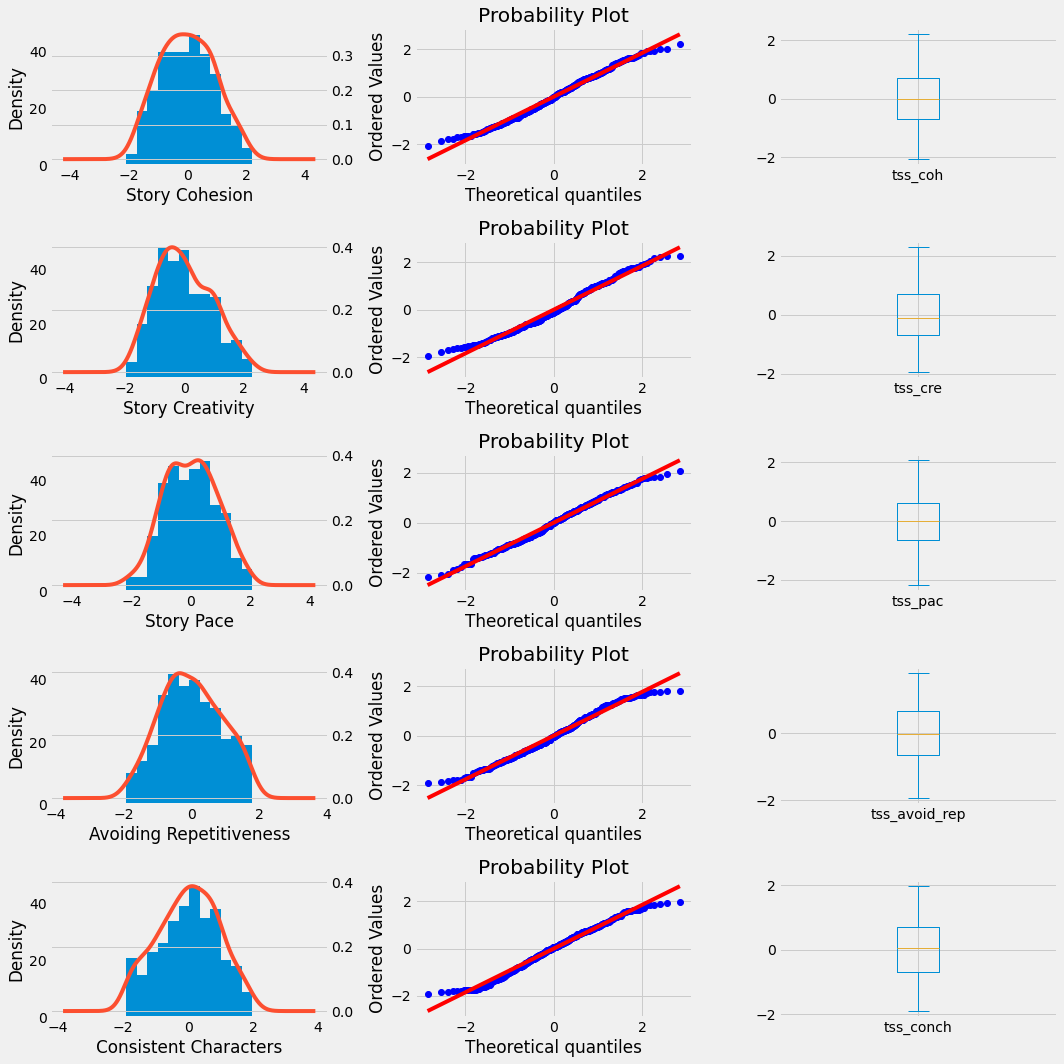

In [49]:
# Check score distributions
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

# Histograms with KDE
ax1 = tss_df["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
tss_df["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = tss_df["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
tss_df["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = tss_df["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
tss_df["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")

ax4 = tss_df["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
tss_df["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Avoiding Repetitiveness")

ax5 = tss_df["tss_conch"].plot.hist(ax=axes[4, 0], bins=12)
tss_df["tss_conch"].plot.kde(ax=axes[4, 0], secondary_y=True)
ax5.set_xlabel("Consistent Characters")

# Q-Q Plots
stats.probplot(tss_df["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(tss_df["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(tss_df["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(tss_df["tss_avoid_rep"], dist="norm", plot=axes[3, 1])
stats.probplot(tss_df["tss_conch"], dist="norm", plot=axes[4, 1])

# Boxplots
tss_df["tss_coh"].plot.box(ax=axes[0, 2])
tss_df["tss_cre"].plot.box(ax=axes[1, 2])
tss_df["tss_pac"].plot.box(ax=axes[2, 2])
tss_df["tss_avoid_rep"].plot.box(ax=axes[3, 2])
tss_df["tss_conch"].plot.box(ax=axes[4, 2])

fig.tight_layout()
plt.show()


# Analyze Impact of Preset & Prompt


<Figure size 720x720 with 0 Axes>

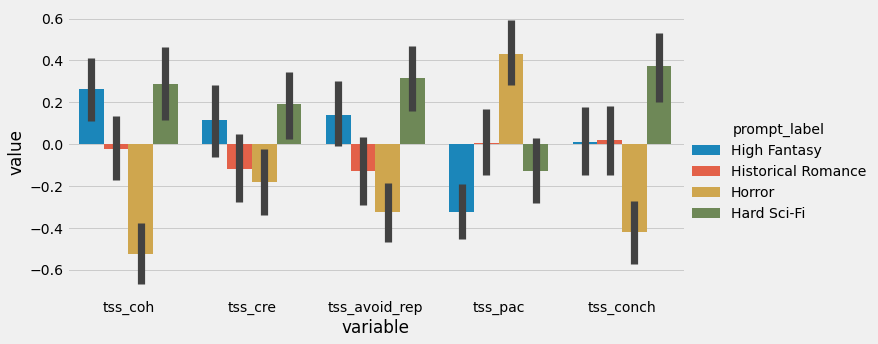

In [50]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "prompt_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.show()


<Figure size 720x720 with 0 Axes>

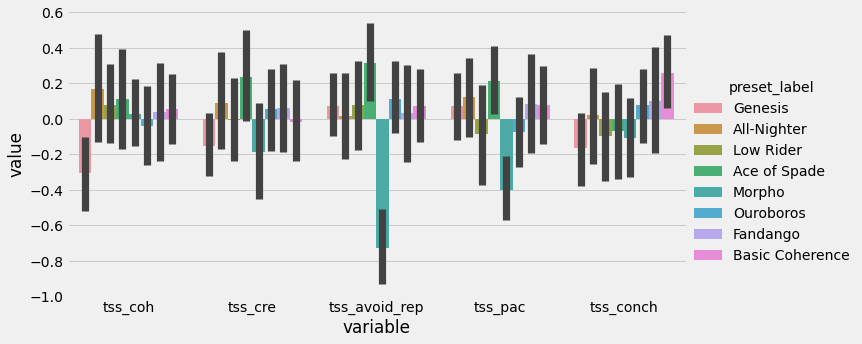

In [51]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "preset_label",
               "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.show()


## Use Word Count as a Control Variable?


<AxesSubplot:xlabel='word_count', ylabel='tss_conch'>

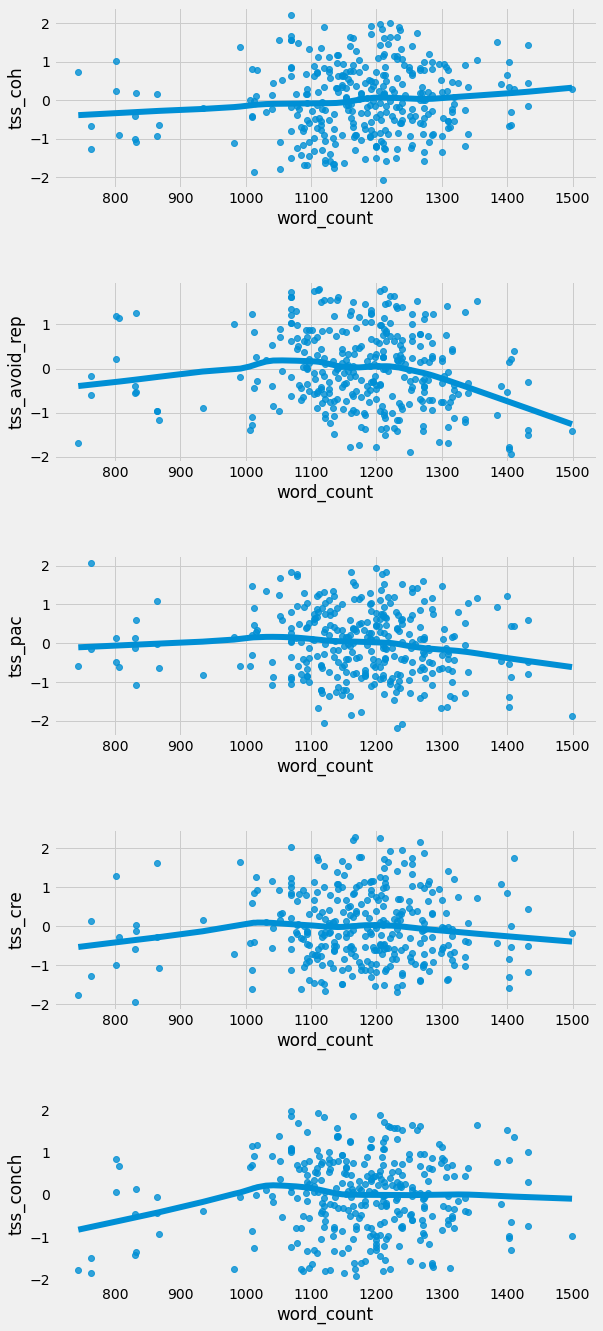

In [52]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_df, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0])
sns.regplot(data=tss_df, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[1])
sns.regplot(data=tss_df, y="tss_pac",
            x="word_count", lowess=True, ax=axes[2])
sns.regplot(data=tss_df, y="tss_cre",
            x="word_count", lowess=True, ax=axes[3])
sns.regplot(data=tss_df, y="tss_conch",
            x="word_count", lowess=True, ax=axes[4])


In [53]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["words_cent"] = tss_df["word_count"].apply(
    lambda x: x-tss_df["word_count"].mean())  # centering

tss_df["words_cent**2"] = tss_df["words_cent"]*tss_df["words_cent"]
tss_df["words_cent**3"] = tss_df["words_cent"]**3
#tss_df["words_cent**4"] = tss_df["words_cent"]**4
#tss_df["words_cent**5"] = tss_df["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA


Model performance for linear model predicting tss_coh:
r-square: -0.0085    RMSE: 0.9119
Model performance for quadratic model predicting tss_coh:
r-square: -0.0130    RMSE: 0.9137
Model performance for cubic model predicting tss_coh:
r-square: -0.0169    RMSE: 0.9155

Model performance for linear model predicting tss_cre:
r-square: -0.0425    RMSE: 0.9282
Model performance for quadratic model predicting tss_cre:
r-square: -0.0399    RMSE: 0.9265
Model performance for cubic model predicting tss_cre:
r-square: -0.0428    RMSE: 0.9279

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0106    RMSE: 0.8752
Model performance for quadratic model predicting tss_avoid_rep:
r-square: 0.0284    RMSE: 0.8577
Model performance for cubic model predicting tss_avoid_rep:
r-square: 0.0201    RMSE: 0.8626

Model performance for linear model predicting tss_pac:
r-square: -0.0464    RMSE: 0.8659
Model performance for quadratic model predicting tss_pac:
r-square: -0.0483    RMSE: 

## ANOVA Model Diagnostics


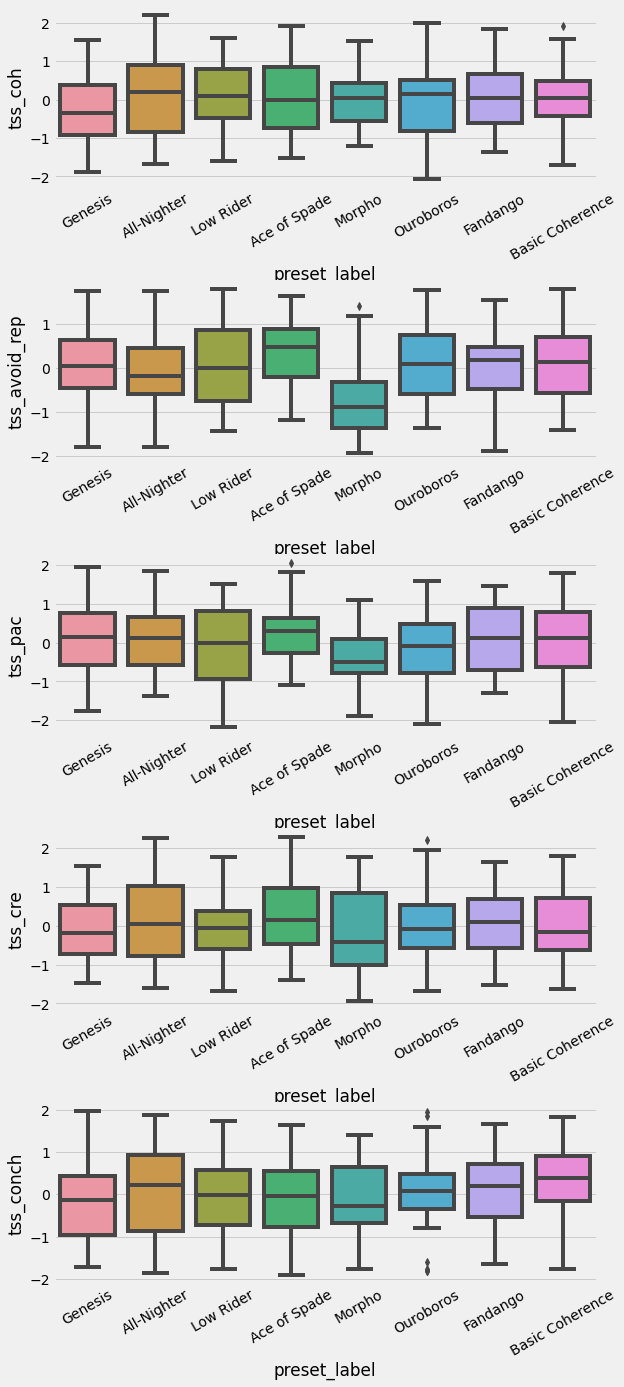

In [54]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

sns.boxplot(x="preset_label", y="tss_coh", data=tss_df, ax=axes[0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=tss_df, ax=axes[1])
sns.boxplot(x="preset_label", y="tss_pac", data=tss_df, ax=axes[2])
sns.boxplot(x="preset_label", y="tss_cre", data=tss_df, ax=axes[3])
sns.boxplot(x="preset_label", y="tss_conch", data=tss_df, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


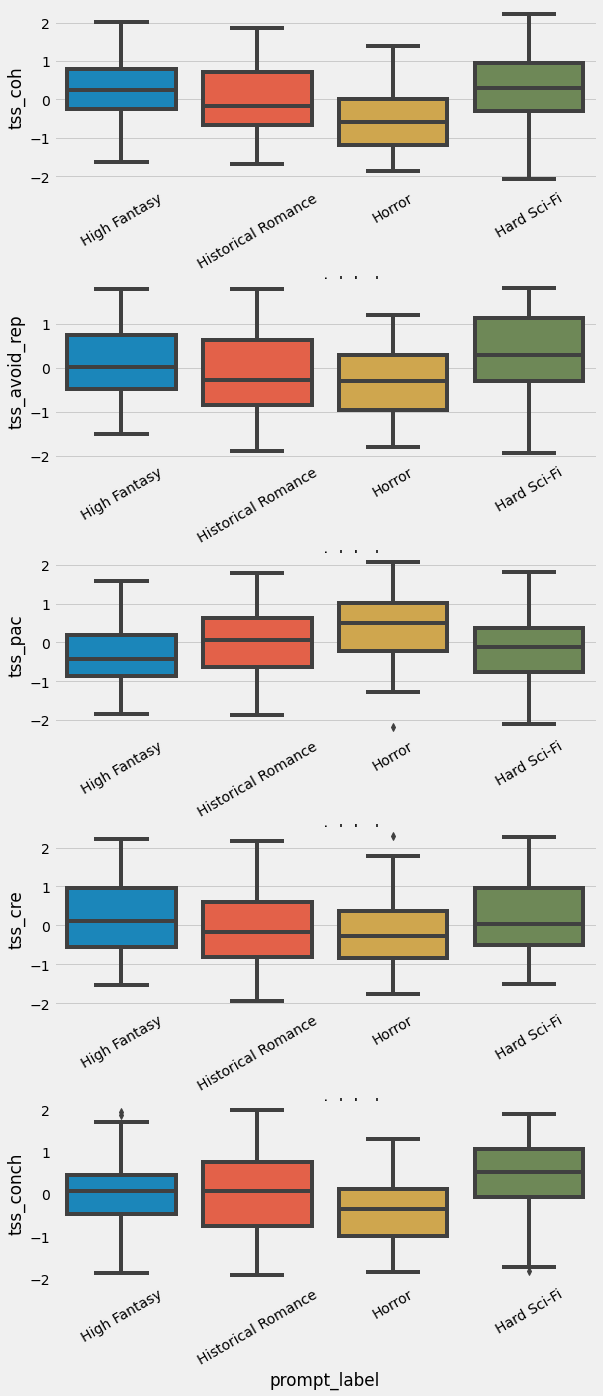

In [55]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=tss_df, ax=axes[0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=tss_df, ax=axes[1])
sns.boxplot(x="prompt_label", y="tss_pac", data=tss_df, ax=axes[2])
sns.boxplot(x="prompt_label", y="tss_cre", data=tss_df, ax=axes[3])
sns.boxplot(x="prompt_label", y="tss_conch", data=tss_df, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


In [56]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)

    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(
            q1, q3, iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")


In [57]:
# Outliers for Presets

# Outliers Coherence
print("Exterme outliers on tss_coh, Basic Coherence preset")
determine_outliers(tss_df[tss_df["preset_label"] ==
                          "Basic Coherence"], "tss_coh")

# Outliers Repitition
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] ==
                          "Morpho"], "tss_avoid_rep")

# Outliers pace
print("\nExterme outliers on tss_pac, Ace of Spade preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ace of Spade"], "tss_pac")

# Outliers creativity
print("\nExterme outliers on tss_cre, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_cre")

# Outliers consistent characterization
print("\nExterme outliers on tss_pac, Ouroboros")
determine_outliers(tss_df[tss_df["preset_label"] ==
                          "Ouroboros"], "tss_conch")

# Outliers for Prompts

# Pace
print("\nExterme outliers on tss_avoid rep, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_avoid_rep")

# Creativity
print("\nExterme outliers on tss_cre, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_cre")


Exterme outliers on tss_coh, Basic Coherence preset
25th Percentile (Q1): -0.44
75th Percentile (Q3): 0.49
IQR: 0.92
Will count cases as outlier with values less than -3.21 or more than 3.26.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Morpho preset
25th Percentile (Q1): -1.37
75th Percentile (Q3): -0.32
IQR: 1.05
Will count cases as outlier with values less than -4.51 or more than 2.81.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Ace of Spade preset
25th Percentile (Q1): -0.26
75th Percentile (Q3): 0.65
IQR: 0.91
Will count cases as outlier with values less than -2.98 or more than 3.37.
With these criteria there are no outlier in the data

Exterme outliers on tss_cre, Ouroboros preset
25th Percentile (Q1): -0.58
75th Percentile (Q3): 0.52
IQR: 1.10
Will count cases as outlier with values less than -3.89 or more than 3.83.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Ouro

In [58]:
#tss_no_out = tss_df[~(tss_df.index == 7)].copy()
tss_no_out = tss_df


In [59]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15, 15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(groups_li), len(vars_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li, vars_li):
        stats.probplot(df[df[group_label] == group][var],
                       dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - " + var)
        if x < (len(vars_li)-1):
            x += 1
        else:
            x = 0
            y += 1


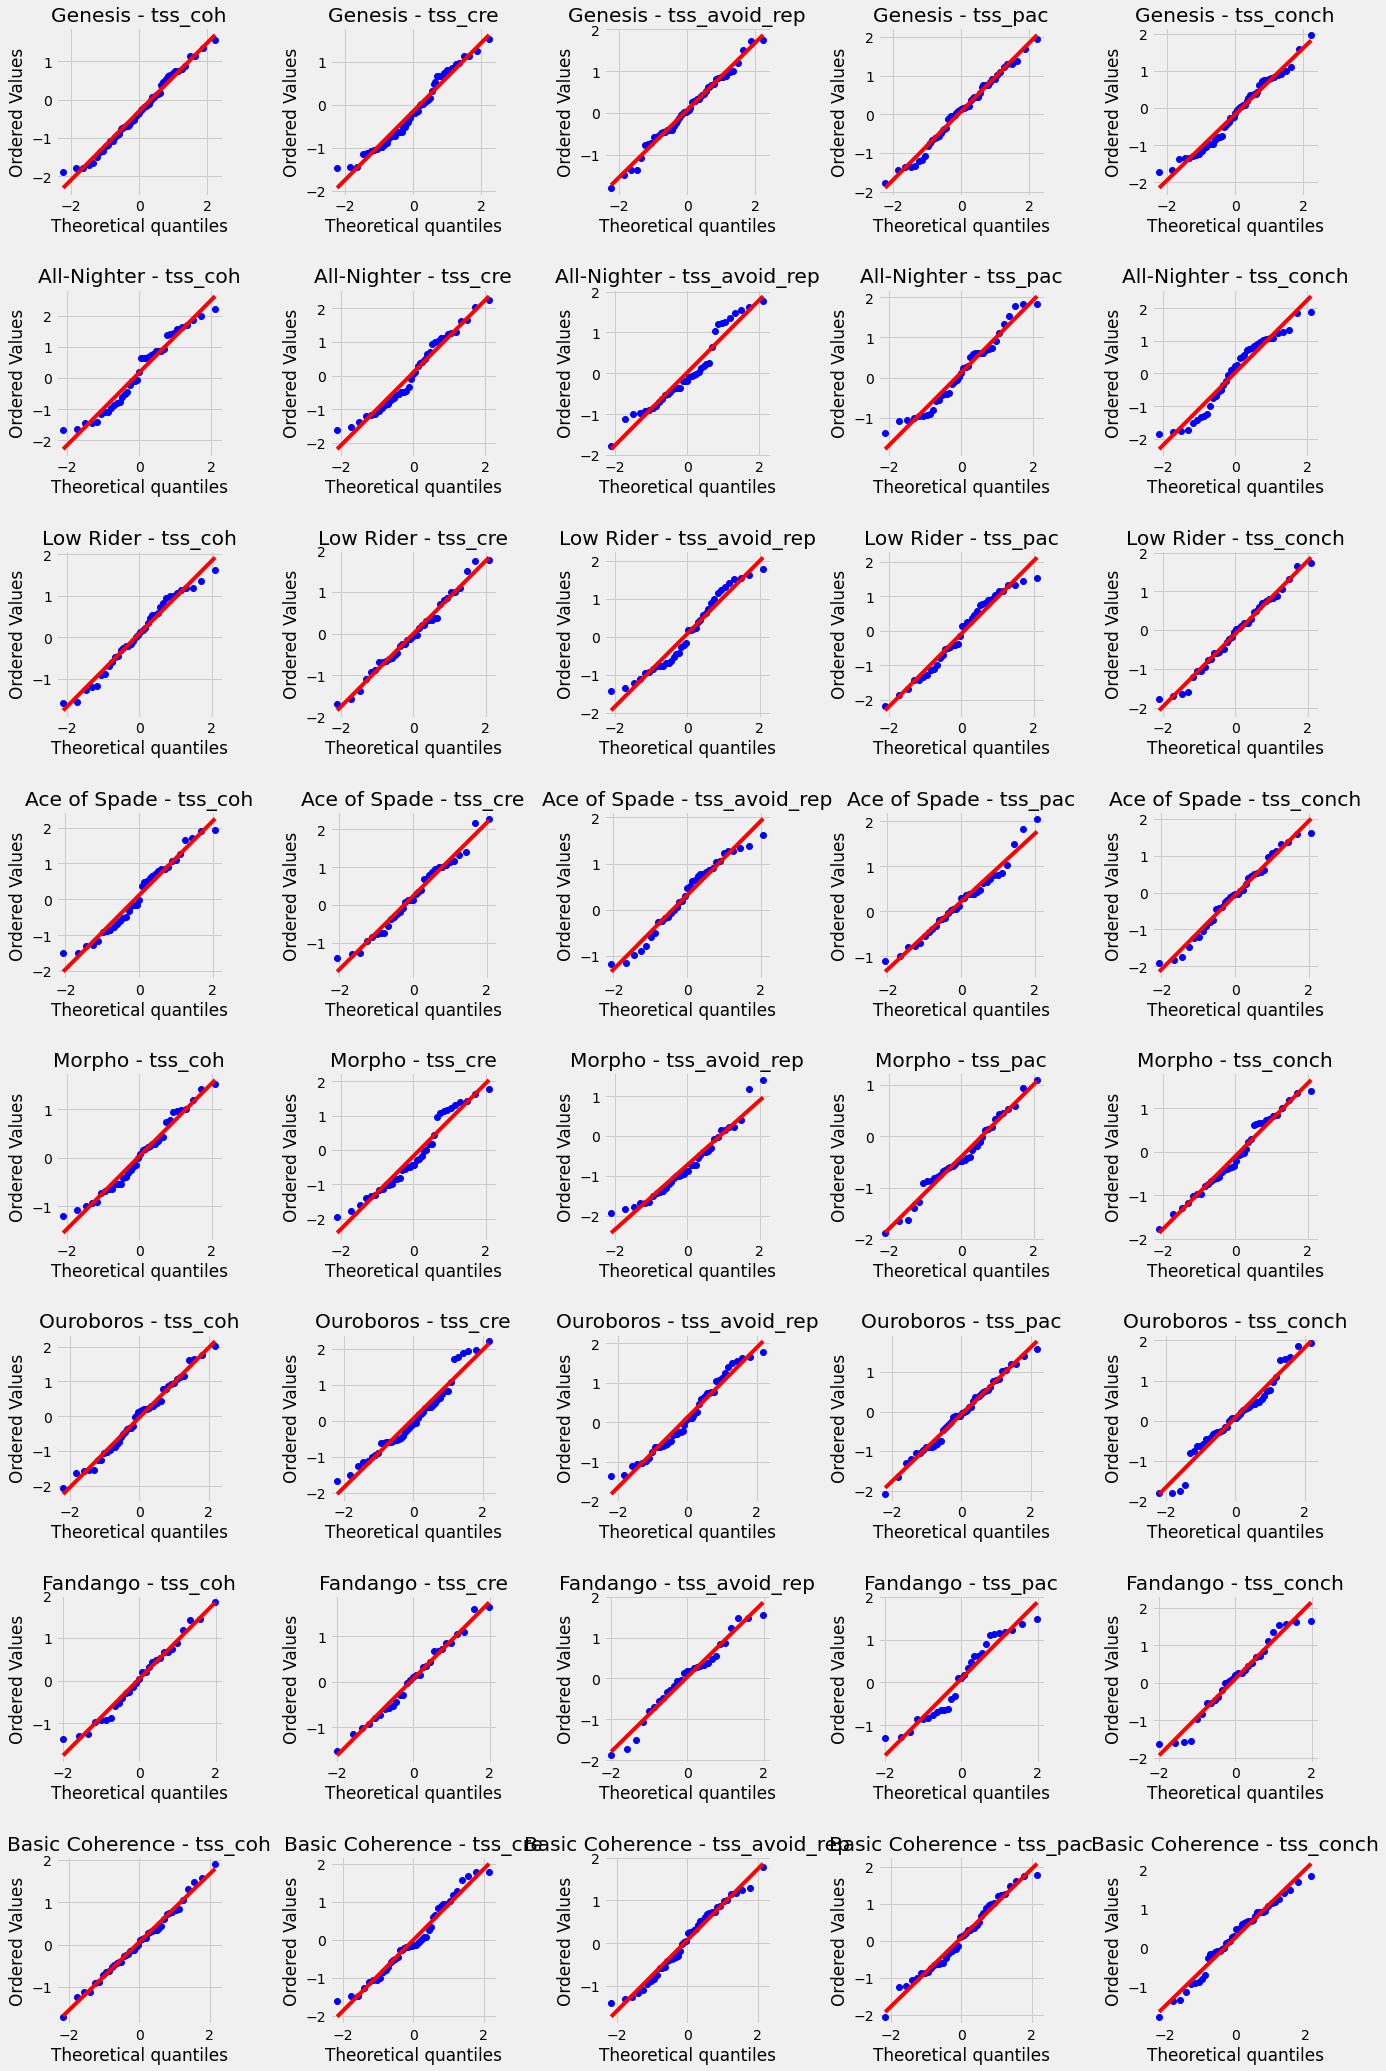

In [60]:
qqs_over_groups_and_vars(tss_no_out, "preset_label", outcome_li, size=(20, 30))


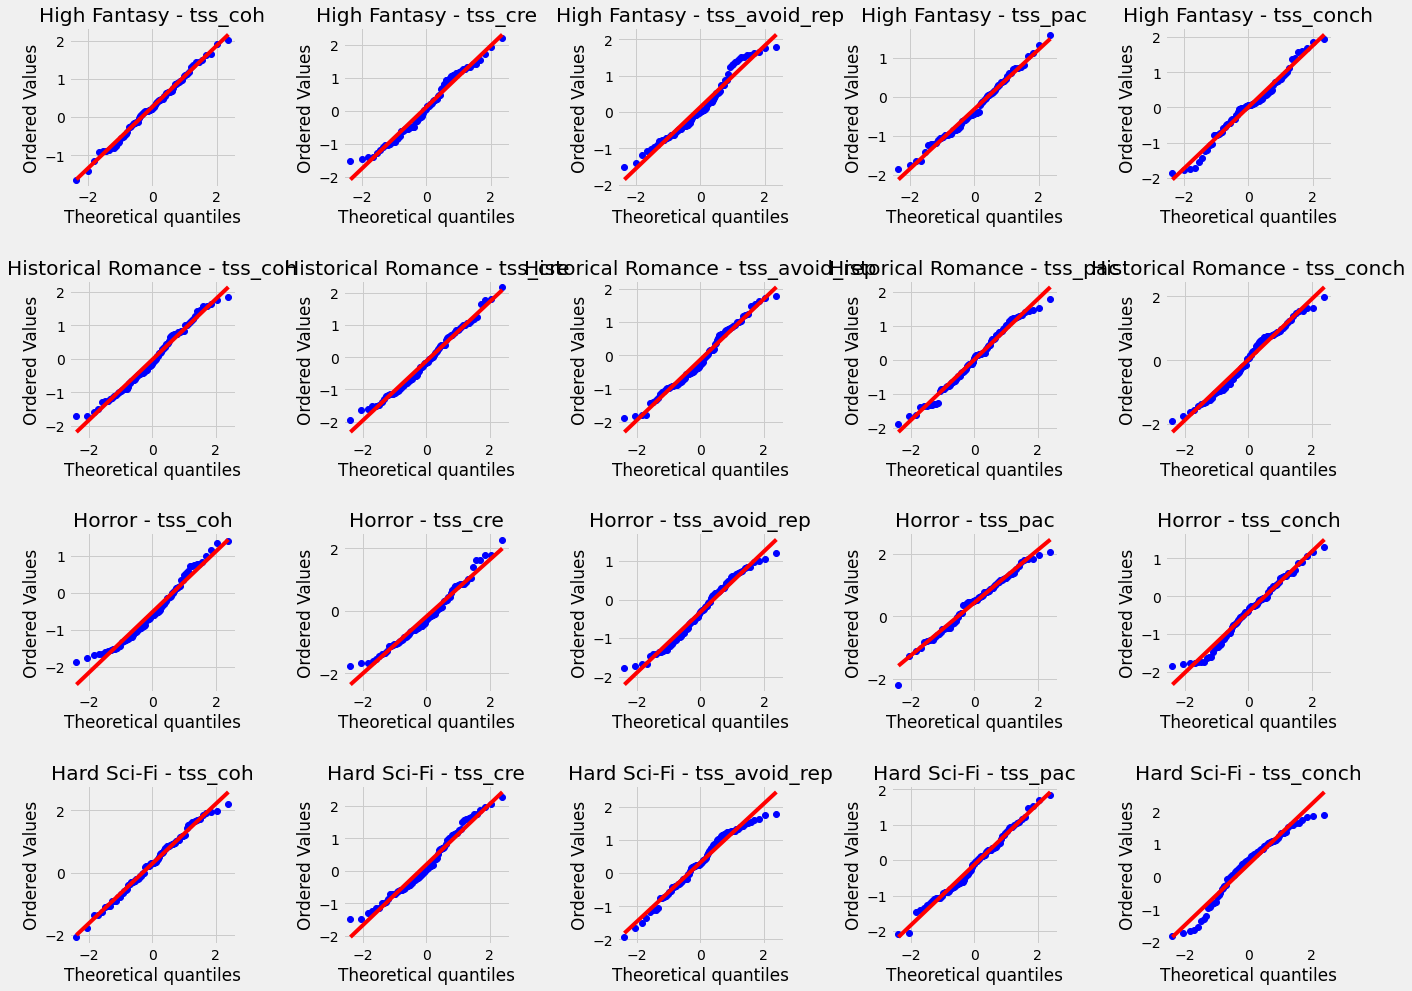

In [61]:
qqs_over_groups_and_vars(tss_no_out, "prompt_label", outcome_li, size=(20, 15))


In [62]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {:.2f}, coefficient of sample size variation is {:.2f}, variance ratio is {:.2f}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")


In [63]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_no_out)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_no_out)
    print("\n")


Checks for tss_coh
Preset
Smallest variance for Morpho: 0.55
Largest variance for All-Nighter: 1.33
Variance ratio for: 2.43
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.05. That is below 0 or over .5. Continuing with further checks...
Pairing is -0.05, so smaller than 0 and larger than or equal to -.5, ,coefficient of sample size variation is 0.30, larger than .16, and variance ratio is 2.43, larger than 2. F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).

Prompt
Smallest variance for High Fantasy: 0.62
Largest variance for Hard Sci-Fi: 0.90
Variance ratio for: 1.44
Variance ratio is smaller or equal to 1.5, F-test will be robust.


Checks for tss_cre
Preset
Smallest variance for Genesis: 0.62
Largest variance for All-Nighter: 1.13
Variance ratio for: 1.82
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.


## Running the ANOVA


In [64]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_no_out).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, tss_no_out).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))

    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")

    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7],
                  outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]

    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10],
                  outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]


tss_coh
                             sum_sq     df          F        PR(>F)
C(preset_label, Sum)       7.012827    7.0   1.342921  2.294600e-01
C(prompt_label, Sum)      36.404968    3.0  16.266522  7.565573e-10
C(sample, Treatment(0))    0.260180    1.0   0.348762  5.552421e-01
Residual                 232.755136  312.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                tss_coh   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5.782
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           1.62e-08
Time:                        14:03:55   Log-Likelihood:                -406.15
No. Observations:                 324   AIC:                             836.3
Df Residuals:                     312   BIC:                             881.7
Df Model:           

In [65]:
params_df.index = params_df.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - \
        params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace(
    "90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_no_out["preset_label"].unique())
prompts_li = list(tss_no_out["prompt_label"].unique())

order_index = ["Intercept", "Panel"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # no adjustement for p necessary for sample source
    params_df.loc["Panel", outcome +
                  " adj_p"] = params_df.loc["Panel", outcome + " p-value"]
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]

    cols_order.extend([outcome, outcome + " p-value",
                       outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]


In [66]:
params_df


,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin,tss_conch,tss_conch p-value,tss_conch adj_p,tss_conch 90% CI margin
Intercept,0.045292,5.455685e-01,NaN,0.123259,-0.127900,0.068945,NaN,0.115669,0.165590,1.941843e-02,NaN,0.116527,0.117358,8.157194e-02,NaN,0.110836,-0.041084,6.058271e-01,NaN,0.130955
Panel,-0.056893,5.548145e-01,5.548145e-01,0.158462,0.276144,0.007577,0.007577,0.170097,-0.340562,1.792474e-04,1.792474e-04,0.149515,-0.234382,1.132830e-02,1.132830e-02,0.152237,0.073213,4.673884e-01,4.673884e-01,0.165706
Genesis,-0.313302,4.698221e-03,3.758577e-02,0.182289,-0.151130,0.167190,0.572329,0.179968,0.088692,4.020994e-01,5.998156e-01,0.174112,0.072067,4.910612e-01,6.028332e-01,0.172142,-0.133275,2.620202e-01,8.878873e-01,0.195445
All-Nighter,0.087591,5.913415e-01,8.670228e-01,0.268348,0.059554,0.687061,0.985608,0.243165,-0.057476,6.388372e-01,7.300997e-01,0.201437,0.151346,2.576924e-01,6.028332e-01,0.219940,-0.035876,8.181160e-01,8.878873e-01,0.256604
Low Rider,0.087746,5.231466e-01,8.670228e-01,0.226043,-0.006386,0.962463,0.985608,0.223198,0.096927,4.367796e-01,5.998156e-01,0.205019,-0.110451,4.765949e-01,6.028332e-01,0.255238,-0.072112,5.914852e-01,8.878873e-01,0.221011
Ace of Spade,0.147833,2.826850e-01,8.670228e-01,0.226344,0.243862,0.103971,0.572329,0.246705,0.371797,2.813157e-03,1.125263e-02,0.204707,0.181217,8.613153e-02,3.445261e-01,0.173687,-0.043863,7.658865e-01,8.878873e-01,0.242302
Morpho,0.012455,9.134491e-01,9.134491e-01,0.188495,-0.188183,0.214623,0.572329,0.249432,-0.716048,2.693505e-09,2.154804e-08,0.197973,-0.396686,4.202411e-04,3.361929e-03,0.184997,-0.093644,4.431333e-01,8.878873e-01,0.200846
Ouroboros,-0.055045,6.502671e-01,8.670228e-01,0.199697,0.033952,0.788028,0.985608,0.207703,0.122722,2.740372e-01,5.998156e-01,0.184547,-0.073946,5.274791e-01,6.028332e-01,0.192496,0.087895,4.550698e-01,8.878873e-01,0.193544
Fandango,-0.028286,8.562691e-01,9.134491e-01,0.256872,0.010750,0.945172,0.985608,0.257125,0.007811,9.597481e-01,9.597481e-01,0.254565,0.126049,3.831036e-01,6.028332e-01,0.237714,0.024223,8.878873e-01,8.878873e-01,0.282616
Basic Coherence,0.061008,5.897329e-01,8.670228e-01,0.186099,-0.002419,0.985608,0.985608,0.220575,0.085575,4.498617e-01,5.998156e-01,0.186275,0.050403,6.612292e-01,6.612292e-01,0.189189,0.266652,2.886883e-02,2.309506e-01,0.200708


In [67]:
adj_p_cols = params_df.columns.str.extractall("(.*adj_p)").values.flatten()
mask_sig = (params_df[adj_p_cols] < 0.1).any(axis=1)

params_df[mask_sig]


,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin,tss_conch,tss_conch p-value,tss_conch adj_p,tss_conch 90% CI margin
Panel,-0.056893,5.548145e-01,5.548145e-01,0.158462,0.276144,0.007577,0.007577,0.170097,-0.340562,1.792474e-04,1.792474e-04,0.149515,-0.234382,1.132830e-02,1.132830e-02,0.152237,0.073213,4.673884e-01,4.673884e-01,0.165706
Genesis,-0.313302,4.698221e-03,3.758577e-02,0.182289,-0.151130,0.167190,0.572329,0.179968,0.088692,4.020994e-01,5.998156e-01,0.174112,0.072067,4.910612e-01,6.028332e-01,0.172142,-0.133275,2.620202e-01,8.878873e-01,0.195445
Ace of Spade,0.147833,2.826850e-01,8.670228e-01,0.226344,0.243862,0.103971,0.572329,0.246705,0.371797,2.813157e-03,1.125263e-02,0.204707,0.181217,8.613153e-02,3.445261e-01,0.173687,-0.043863,7.658865e-01,8.878873e-01,0.242302
Morpho,0.012455,9.134491e-01,9.134491e-01,0.188495,-0.188183,0.214623,0.572329,0.249432,-0.716048,2.693505e-09,2.154804e-08,0.197973,-0.396686,4.202411e-04,3.361929e-03,0.184997,-0.093644,4.431333e-01,8.878873e-01,0.200846
High Fantasy,0.281208,7.331144e-04,1.466229e-03,0.136974,0.132795,0.141201,0.141201,0.148456,0.149614,5.973307e-02,7.964410e-02,0.130709,-0.309363,7.050624e-05,1.410125e-04,0.128028,0.028896,7.408181e-01,8.386588e-01,0.143693
Horror,-0.519719,1.204869e-10,4.819477e-10,0.132769,-0.200236,0.023578,0.064580,0.145481,-0.325555,1.579931e-05,6.319724e-05,0.124035,0.452431,8.310920e-09,3.324368e-08,0.129153,-0.419707,1.303434e-07,5.213738e-07,0.130790
Hard Sci-Fi,0.270234,1.861171e-03,2.481561e-03,0.142854,0.195466,0.032290,0.064580,0.150183,0.294575,2.954436e-04,5.908871e-04,0.133876,-0.153350,7.138807e-02,9.518410e-02,0.139899,0.372524,4.036428e-05,8.072856e-05,0.149254


In [68]:
tss_no_out["preset_label"].value_counts()


Genesis            53
Ouroboros          48
Basic Coherence    44
All-Nighter        39
Low Rider          38
Morpho             38
Ace of Spade       35
Fandango           29
Name: preset_label, dtype: int64

In [69]:
# labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# # create dicts with a key for each preset with an empty list as value for each
# marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
# yerr_dict = {preset: [] for preset in params_df[1:8].index}
# #colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

# for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
#     marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
#     yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

# figure = plt.figure(figsize=(10, 5))

# x = np.arange(len(labels)) # label locations
# width = 0.35 # width of bars

# plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
#         yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")
# plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
#         yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")


# i = 0
# pos = -0.4
# for outcome in outcome_li:
#     grand_mean = params_df.loc["Intercept", outcome]
#     ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
#     if i == 0:
#         ax[0].set_label("Grand Mean (all Presets)")
#     i += 1
#     pos += 1

# plt.ylim(1,5)
# plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
# plt.xticks(x, labels, fontsize = 16)

# plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
# leg = plt.gca().get_legend()
# plt.grid(False)
# #plt.title("Genesis & Low Rider")
# #figure.tight_layout()
# plt.show()

# figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")


## Visualizing the Results


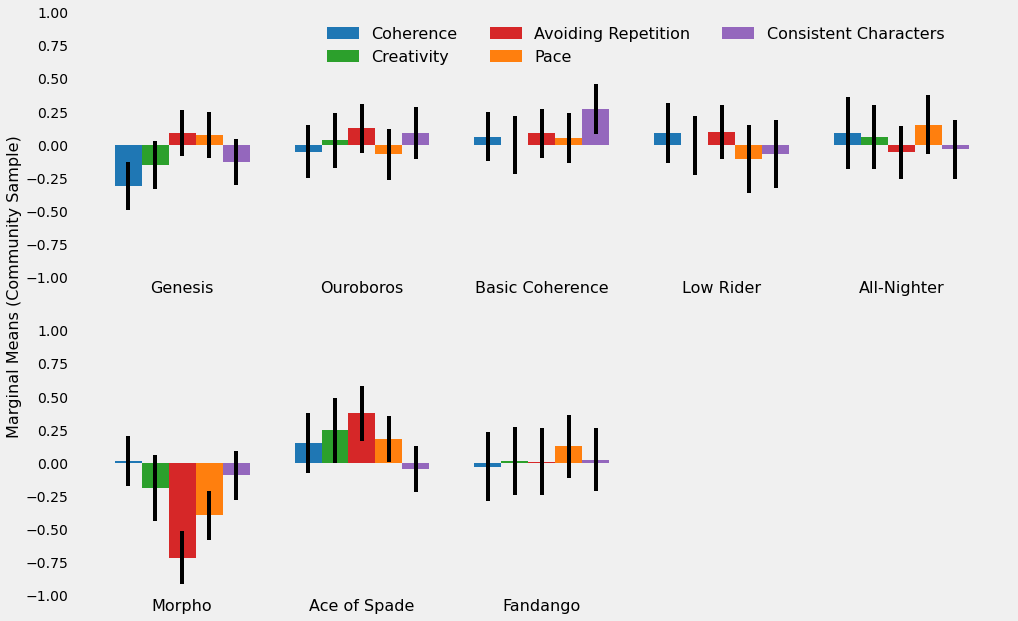

In [70]:
labels = ["Coherence", "Creativity",
          "Avoiding Repitition", "Pace", "Consistent Characters"]
presets_1 = ["Genesis", "Ouroboros",
             "Basic Coherence", "Low Rider", "All-Nighter"]
presets_2 = ["Morpho", "Ace of Spade", "Fandango"]

preset_to_graph = [presets_1, presets_2]

max_n_presets = max([len(x) for x in preset_to_graph])

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# fig.tight_layout(pad=5.0)
plt.setp(axes, ylim=(-1, 1))
fig.text(0.02, 0.5, "Marginal Means (Community Sample)",
         va='center', rotation='vertical', fontsize=16)

i = 0
for pre_li in preset_to_graph:

    # create dicts with a key for each outcome with an empty list as value for each
    # values are centered around the mean for the community sample (!)
    # so a value of 0 is exactly the expected mean for the community sample
    marginal_means_dict = {outcome: [] for outcome in outcome_li}
    yerr_dict = {outcome: [] for outcome in outcome_li}

    prod_presets_outcomes = itertools.product(pre_li, outcome_li)

    for preset, outcome in prod_presets_outcomes:
        marginal_means_dict[outcome].append(params_df.loc[preset, outcome])
        yerr_dict[outcome].append(
            params_df.loc[preset, outcome + " 90% CI margin"])

    # Compute difference in length to longest row
    diff_len = max_n_presets - len(pre_li)

    # fill up dictonaries with 0 if less values than the longest row
    if diff_len > 0:
        for outcome in outcome_li:
            marginal_means_dict[outcome].extend([0]*diff_len)
            yerr_dict[outcome].extend([0]*diff_len)

    x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
    width = 0.15  # width of bars

    cur_ax = axes[i]
    n_presets = len(pre_li)

    x_labels = pre_li
    x_labels.extend([""]*diff_len)

    cur_ax.set_xticks(x)
    cur_ax.set_xticklabels(x_labels, fontsize=16)

    cur_ax.bar(x-0.3, marginal_means_dict["tss_coh"], width,
               yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

    cur_ax.bar(x-0.15, marginal_means_dict["tss_cre"], width,
               yerr=yerr_dict["tss_cre"], label="Creativity", color="tab:green")

    cur_ax.bar(x, marginal_means_dict["tss_avoid_rep"], width,
               yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

    cur_ax.bar(x+0.15, marginal_means_dict["tss_pac"], width,
               yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

    cur_ax.bar(x+0.3, marginal_means_dict["tss_conch"], width,
               yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

    cur_ax.grid(False)

    i += 1

axes[0].legend(frameon=False, fontsize=16, loc='upper center',
               ncol=3, bbox_to_anchor=(0.6, 1))

# fig.tight_layout()
plt.show()

fig.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")


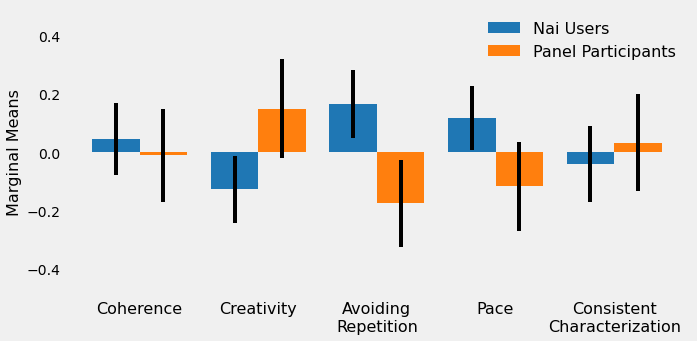

In [71]:
# graph for Community vs Panel

# create dicts with a key for pe sample source with an empty list as value for each
marginal_means_dict = {"Community": [], "Panel": []}
yerr_dict = {"Community": [], "Panel": []}

outcome_labels = ["Coherence", "Creativity",
                  "Avoiding\nRepetition", "Pace", "Consistent\nCharacterization"]

for outcome in outcome_li:
    marginal_means_dict["Community"].append(
        params_df.loc["Intercept", outcome])
    yerr_dict["Community"].append(
        params_df.loc["Intercept", outcome + " 90% CI margin"])

    marginal_means_dict["Panel"].append(
        params_df.loc["Intercept", outcome] + params_df.loc["Panel", outcome])
    yerr_dict["Panel"].append(
        params_df.loc["Panel", outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["Community"]))  # label locations
width = 0.4  # width of bars

plt.bar(x-0.2, marginal_means_dict["Community"], width,
        yerr=yerr_dict["Community"], label="Nai Users", color="tab:blue")
plt.bar(x+0.2, marginal_means_dict["Panel"], width,
        yerr=yerr_dict["Panel"], label="Panel Participants", color="tab:orange")

plt.ylim(-0.5, 0.5)
plt.ylabel("Marginal Means", fontsize=16)
plt.xticks(x, outcome_labels, fontsize=16)

plt.legend(frameon=False, fontsize=16, loc='upper right')
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/community_vs_panel.png', bbox_inches="tight")


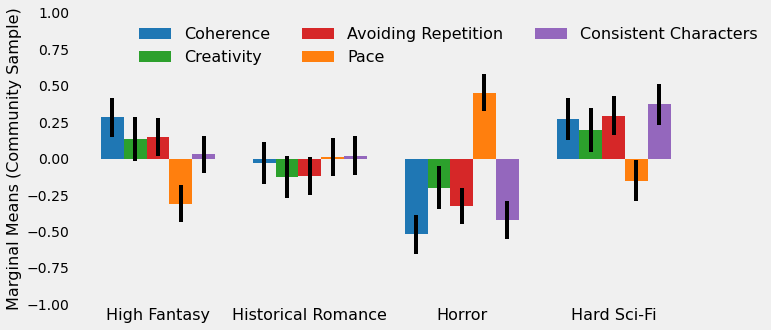

In [72]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}

for prompt, outcome in itertools.product(prompts_li, outcome_li):
    marginal_means_dict[outcome].append(params_df.loc[prompt, outcome])
    yerr_dict[outcome].append(
        params_df.loc[prompt, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.15  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.15, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Creativity", color="tab:green")

plt.bar(x, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.15, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.bar(x+0.3, marginal_means_dict["tss_conch"], width,
        yerr=yerr_dict["tss_pac"], label="Consistent Characters", color="tab:purple")

plt.ylim(-1, 1)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts_li, fontsize=16)

plt.legend(frameon=False, fontsize=16, loc='upper center',
           ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")


# Analyze Consistency of Story Aspects Across Presets & Prompts


In [73]:
for outcome in outcome_li:
    print(("_"*75) + "\n")
    print("\033[1m{}\033[0m".format(outcome))

    homo_res = pg.homoscedasticity(
        tss_no_out, dv=outcome, group="preset_label", method="levene", alpha=0.1)
    print("Omnibus Test for homoscedasticity across presets")
    print(homo_res.round(3))

    if homo_res.iloc[0, 2] == False:
        print("\nVariances are not equal, doing posthoc tests")
        print(f"Average SD: {tss_no_out[outcome].std():.2f}")
        print("\nPresets with adjusted p-vals < .15 displayed below:")

        posthoc_dict = {}
        for preset in presets_li:
            data_preset = tss_no_out[tss_no_out["preset_label"]
                                     == preset][outcome].to_numpy()
            data_rest = tss_no_out[tss_no_out["preset_label"]
                                   != preset][outcome].to_numpy()
            posthoc_dict[preset] = pg.homoscedasticity(
                [data_preset, data_rest], method="levene", alpha=0.1)

        ps_li = []
        for dv in posthoc_dict:
            ps_li.append(posthoc_dict[dv].iloc[0, 1])
        adj_ps_li = fdrcorrection(ps_li, alpha=0.1)[1]

        i = 0
        for dv in posthoc_dict:
            posthoc_dict[dv].loc["levene",
                                 "sd"] = tss_no_out[tss_no_out["preset_label"] == dv][outcome].std()
            posthoc_dict[dv].loc["levene", "adj_p"] = adj_ps_li[i]
            if posthoc_dict[dv].loc["levene", "adj_p"] < 0.15:
                print(f"\n{dv}")
                print(posthoc_dict[dv].round(3))
            i += 1

    homo_res = pg.homoscedasticity(
        tss_no_out, dv=outcome, group="prompt_label", method="levene", alpha=0.1)
    print("-"*75)
    print("\nOmnibus Test for homoscedasticity across prompts")
    print(f"{homo_res.round(3)}\n")


___________________________________________________________________________

tss_coh
Omnibus Test for homoscedasticity across presets
            W  pval  equal_var
levene  2.677  0.01      False

Variances are not equal, doing posthoc tests
Average SD: 0.92

Presets with adjusted p-vals < .15 displayed below:

All-Nighter
             W   pval  equal_var     sd  adj_p
levene  10.339  0.001      False  1.151  0.011

Morpho
            W   pval  equal_var     sd  adj_p
levene  3.679  0.056      False  0.739  0.149

Basic Coherence
            W   pval  equal_var     sd  adj_p
levene  4.219  0.041      False  0.786  0.149
---------------------------------------------------------------------------

Omnibus Test for homoscedasticity across prompts
            W   pval  equal_var
levene  1.305  0.273       True

___________________________________________________________________________

tss_cre
Omnibus Test for homoscedasticity across presets
            W   pval  equal_var
levene  1.182  

## Visualize Findings


In [74]:
def hist_over_groups(df, var, var_name, group_label, groups_li,
                     bins_n=10, xlim=(-3, 3), size=(15, 15),
                     plot_avg=True):
    n_plots = len(groups_li)+1 if plot_avg else len(groups_li)
    fig, axes = plt.subplots(1, n_plots, figsize=size)
    fig.tight_layout(pad=5.0)

    x = 0

    if plot_avg:
        df[var].plot.hist(ax=axes[x], bins=bins_n)
        df[var].plot.kde(ax=axes[x], secondary_y=True)
        axes[x].set_xlim(xlim)
        axes[x].set_title(f"{var_name} - Average")
        plt.grid(False)
        x += 1

    for group in groups_li:
        df_group = df[df[group_label] == group]
        df_group[var].plot.hist(ax=axes[x], bins=bins_n)
        df_group[var].plot.kde(ax=axes[x], secondary_y=True)
        axes[x].set_xlim(xlim)
        axes[x].set_title(f"{var_name} - {group}")
        plt.grid(False)
        x += 1


def box_over_groups(df, var, var_name, group_label, groups_li,
                    ylim=(-3, 3), size=(15, 15),
                    plot_avg=True, save_plot=False):
    n_plots = len(groups_li)+1 if plot_avg else len(groups_li)
    fig, axes = plt.subplots(1, n_plots, figsize=size)
    fig.tight_layout(pad=5.0)

    x = 0

    if plot_avg:
        sns.boxplot(y=df[var], ax=axes[x])
        axes[x].set_ylim(ylim)
        axes[x].set_title(f"{var_name} - Average")
        axes[x].grid(False)
        x += 1

    for group in groups_li:
        df_group = df[df[group_label] == group]
        sns.boxplot(y=df_group[var], ax=axes[x])
        axes[x].set_ylim(ylim)
        axes[x].set_title(f"{var_name} - {group}")
        axes[x].grid(False)
        x += 1

    if save_plot:
        fig.savefig(save_plot, bbox_inches="tight")


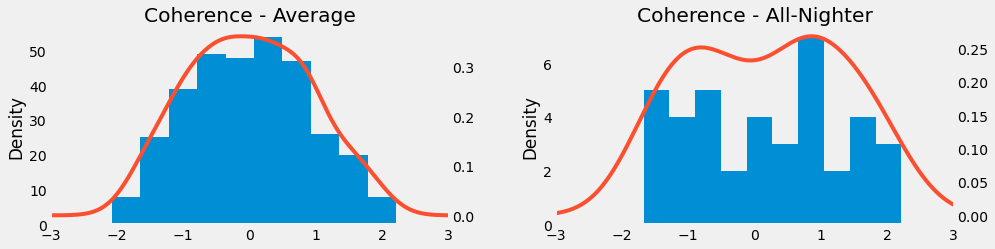

In [75]:
hist_over_groups(tss_no_out, "tss_coh", "Coherence",
                 "preset_label", ["All-Nighter"],
                 size=(15, 5))


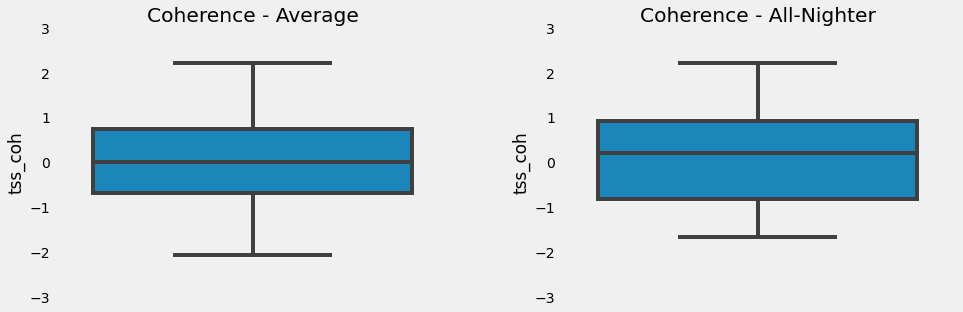

In [76]:
box_over_groups(tss_no_out, "tss_coh", "Coherence",
                "preset_label", ["All-Nighter"],
                size=(15, 6), save_plot="graphs/box_coh.png")


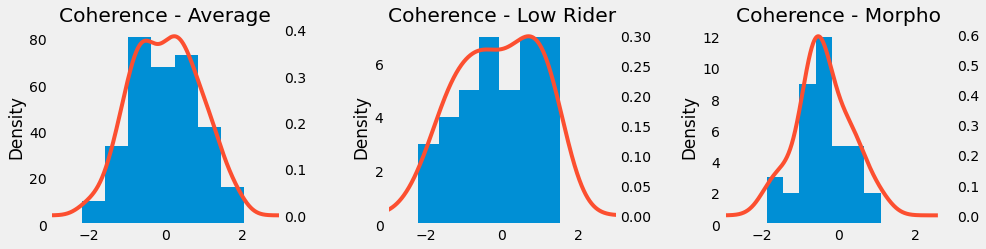

In [77]:
hist_over_groups(tss_no_out, "tss_pac", "Coherence",
                 "preset_label", ["Low Rider", "Morpho"],
                 size=(15, 5), bins_n=7)


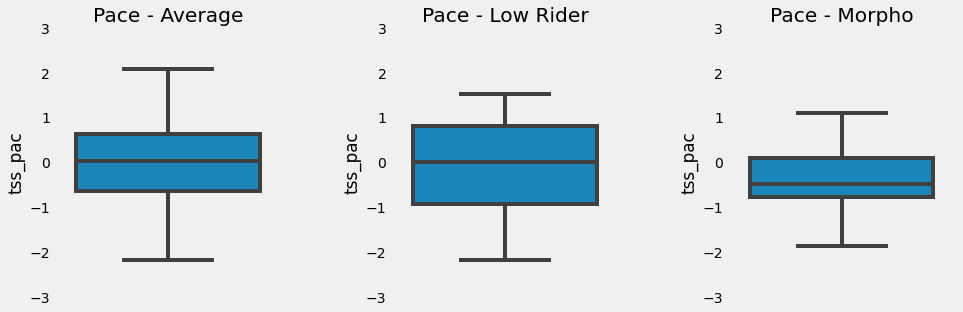

In [78]:
box_over_groups(tss_no_out, "tss_pac", "Pace",
                "preset_label", ["Low Rider", "Morpho"],
                size=(15, 6), save_plot="graphs/box_pac.png")


In [79]:
tss_no_out[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre", "tss_conch",
            "tss_cre_4",
            "tss_qua_1", "tss_qua_2"]].corr(method="kendall")


,tss_coh,tss_avoid_rep,tss_pac,tss_cre,tss_conch,tss_cre_4,tss_qua_1,tss_qua_2
tss_coh,1.000000,0.133547,-0.083362,0.264993,0.353476,0.047558,0.329144,0.359122
tss_avoid_rep,0.133547,1.000000,0.160608,0.193326,0.203990,0.141644,0.209591,0.276991
tss_pac,-0.083362,0.160608,1.000000,0.203990,0.023850,0.261874,0.215775,0.080933
tss_cre,0.264993,0.193326,0.203990,1.000000,0.234224,0.432420,0.571057,0.649284
tss_conch,0.353476,0.203990,0.023850,0.234224,1.000000,0.179897,0.251255,0.307812
tss_cre_4,0.047558,0.141644,0.261874,0.432420,0.179897,1.000000,0.387107,0.285654
tss_qua_1,0.329144,0.209591,0.215775,0.571057,0.251255,0.387107,1.000000,0.502791
tss_qua_2,0.359122,0.276991,0.080933,0.649284,0.307812,0.285654,0.502791,1.000000


In [80]:
items_descr[["tss_cre_4", "tss_qua_1", "tss_qua_2", "tss_qua_3",
             "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]


item_label
tss_cre_4                             The story was creative.
tss_qua_1                           This story was enjoyable.
tss_qua_2                      This story is of high quality.
tss_qua_3                          The story was fun to read.
tss_qua_5                               The story felt vivid.
tss_qua_6                                 I liked this story.
tss_qua_7    I would like to read more stories like this one.
tss_qua_8                         The story was well-written.
Name: item description, dtype: object

<AxesSubplot:xlabel='tss_qua_1', ylabel='preset_label'>

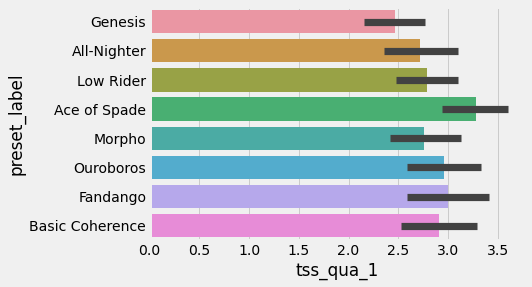

In [81]:
# qual = tss_no_out.groupby('preset_label').mean(
# )[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_1")

# figure = plt.figure(figsize=(10, 5))
sns.barplot(x="tss_qua_1", y="preset_label", data=tss_no_out)
#plt.bar(qual.index, qual["tss_qua_1"])
# plt.xticks(rotation=45)


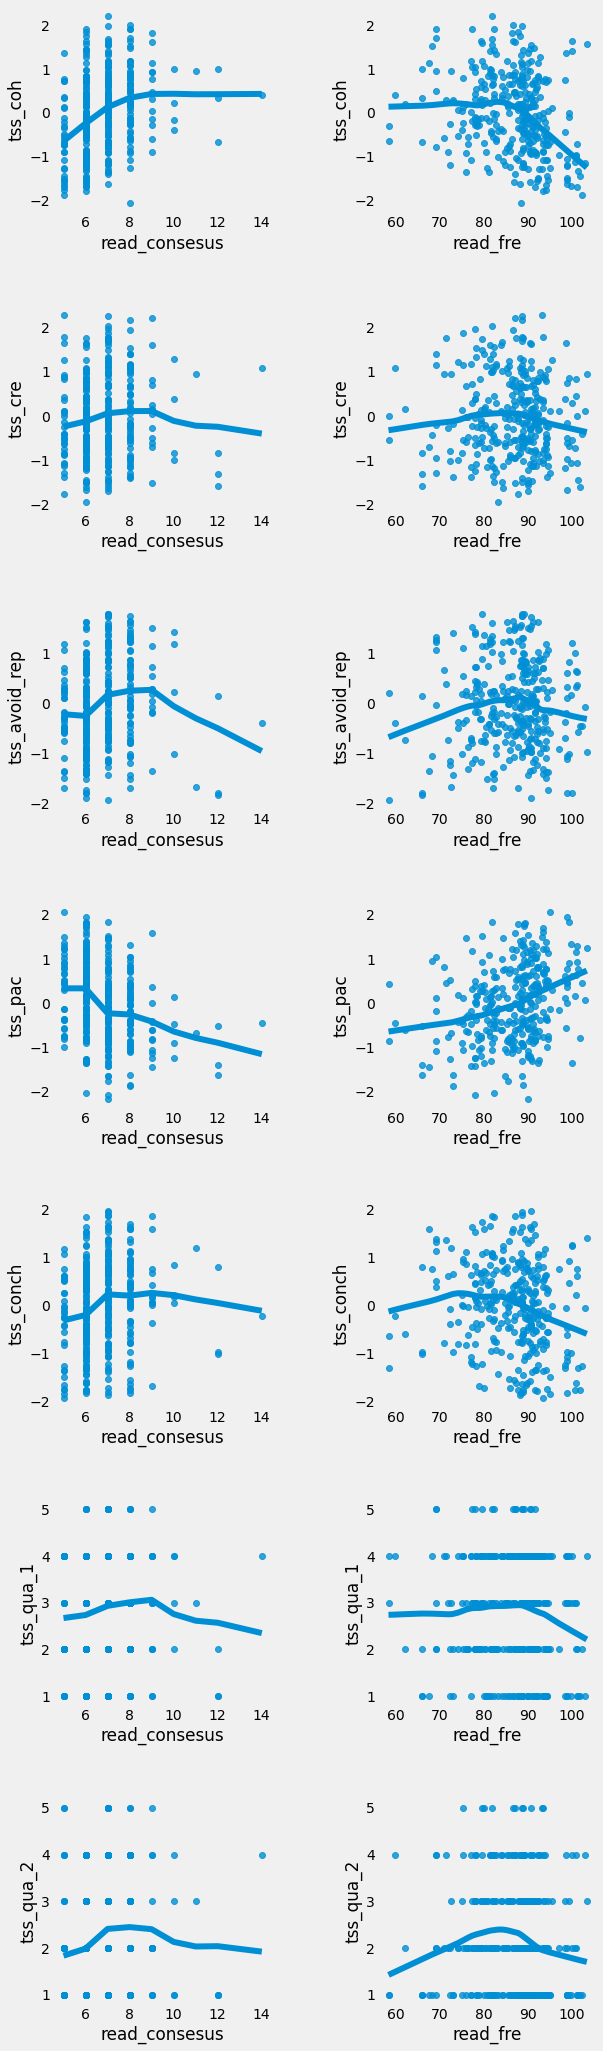

In [82]:
fig, axes = plt.subplots(7, 2, figsize=(10, 30))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_consesus", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_no_out, y="tss_coh",
            x="read_fre", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_consesus", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_no_out, y="tss_cre",
            x="read_fre", lowess=True, ax=axes[1, 1])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_consesus", lowess=True, ax=axes[2, 0])
sns.regplot(data=tss_no_out, y="tss_avoid_rep",
            x="read_fre", lowess=True, ax=axes[2, 1])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_consesus", lowess=True, ax=axes[3, 0])
sns.regplot(data=tss_no_out, y="tss_pac",
            x="read_fre", lowess=True, ax=axes[3, 1])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_consesus", lowess=True, ax=axes[4, 0])
sns.regplot(data=tss_no_out, y="tss_conch",
            x="read_fre", lowess=True, ax=axes[4, 1])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_consesus", lowess=True, ax=axes[5, 0])
sns.regplot(data=tss_no_out, y="tss_qua_1",
            x="read_fre", lowess=True, ax=axes[5, 1])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_consesus", lowess=True, ax=axes[6, 0])
sns.regplot(data=tss_no_out, y="tss_qua_2",
            x="read_fre", lowess=True, ax=axes[6, 1])
for ax in fig.axes:
    ax.grid(False)

plt.show()


In [83]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["read_cent"] = tss_df["read_consesus"].apply(
    lambda x: x-tss_df["read_consesus"].mean())  # centering

tss_df["read_cent**2"] = tss_df["read_cent"]*tss_df["read_cent"]
tss_df["read_cent**3"] = tss_df["read_cent"]**3
tss_df["read_cent**4"] = tss_df["read_cent"]**4
tss_df["read_cent**5"] = tss_df["read_cent"]**5

lin_model = linreg()

pred_li = [("linear", "read_cent"), ("quadratic", "read_cent**2"),
           ("cubic", "read_cent**3"), ("quartic", "read_cent**4"),
           ("quintic", "read_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep",
              "tss_pac", "tss_conch", "tss_qua_1", "tss_qua_2",
              "tss_sty_5", "tss_sty_5"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")


Model performance for linear model predicting tss_coh:
r-square: 0.0612    RMSE: 0.8789
Model performance for quadratic model predicting tss_coh:
r-square: 0.0823    RMSE: 0.8687
Model performance for cubic model predicting tss_coh:
r-square: 0.0787    RMSE: 0.8701
Model performance for quartic model predicting tss_coh:
r-square: 0.0726    RMSE: 0.8730
Model performance for quintic model predicting tss_coh:
r-square: -0.0087    RMSE: 0.9120

Model performance for linear model predicting tss_cre:
r-square: -0.0334    RMSE: 0.9241
Model performance for quadratic model predicting tss_cre:
r-square: -0.0597    RMSE: 0.9339
Model performance for cubic model predicting tss_cre:
r-square: -0.1581    RMSE: 0.9660
Model performance for quartic model predicting tss_cre:
r-square: -0.1170    RMSE: 0.9519
Model performance for quintic model predicting tss_cre:
r-square: -3.5533    RMSE: 1.3268

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0100    RMSE: 0.8756
Model per

In [84]:
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch"]

marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros", "Basic Coherence", "Low Rider",
                               "All-Nighter", "Morpho", "Ace of Spade", "Fandango"],
                              ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac", "tss_conch",
                               "tss_coh 90% CI margin", "tss_cre 90% CI margin",
                               "tss_avoid_rep 90% CI margin", "tss_pac 90% CI margin",
                               "tss_conch 90% CI margin",
                               "tss_coh adj_p", "tss_cre adj_p",
                               "tss_avoid_rep adj_p", "tss_pac adj_p",
                               "tss_conch adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho", "Ace of Spade", "Fandango"], outcome] = marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho", "Ace of Spade", "Fandango"], outcome].apply(
        lambda x: marg_means_df.loc["Intercept", outcome]+x)

marg_means_df.rename(index={"Intercept": "Grand Mean"}, inplace=True)
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_cre", "Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_pac", "Pace")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_conch", "Consistent Characters")


In [85]:
marg_means_df


,Coherence,Creativity,Avoiding Repitition,Pace,Consistent Characters,Coherence 90% CI margin,Creativity 90% CI margin,Avoiding Repitition 90% CI margin,Pace 90% CI margin,Consistent Characters 90% CI margin,Coherence adj_p,Creativity adj_p,Avoiding Repitition adj_p,Pace adj_p,Consistent Characters adj_p
Grand Mean,0.045292,-0.127900,0.165590,0.117358,-0.041084,0.123259,0.115669,0.116527,0.110836,0.130955,NaN,NaN,NaN,NaN,NaN
Genesis,-0.268009,-0.279030,0.254281,0.189425,-0.174359,0.182289,0.179968,0.174112,0.172142,0.195445,0.037586,0.572329,5.998156e-01,0.602833,0.887887
Ouroboros,-0.009752,-0.093948,0.288311,0.043412,0.046811,0.199697,0.207703,0.184547,0.192496,0.193544,0.867023,0.985608,5.998156e-01,0.602833,0.887887
Basic Coherence,0.106300,-0.130319,0.251164,0.167761,0.225567,0.186099,0.220575,0.186275,0.189189,0.200708,0.867023,0.985608,5.998156e-01,0.661229,0.230951
Low Rider,0.133038,-0.134286,0.262517,0.006907,-0.113196,0.226043,0.223198,0.205019,0.255238,0.221011,0.867023,0.985608,5.998156e-01,0.602833,0.887887
All-Nighter,0.132883,-0.068346,0.108114,0.268703,-0.076961,0.268348,0.243165,0.201437,0.219940,0.256604,0.867023,0.985608,7.300997e-01,0.602833,0.887887
Morpho,0.057748,-0.316083,-0.550459,-0.279328,-0.134729,0.188495,0.249432,0.197973,0.184997,0.200846,0.913449,0.572329,2.154804e-08,0.003362,0.887887
Ace of Spade,0.193125,0.115962,0.537387,0.298575,-0.084947,0.226344,0.246705,0.204707,0.173687,0.242302,0.867023,0.572329,1.125263e-02,0.344526,0.887887
Fandango,0.017007,-0.117150,0.173400,0.243407,-0.016862,0.256872,0.257125,0.254565,0.237714,0.282616,0.913449,0.985608,9.597481e-01,0.602833,0.887887


In [86]:
# Update GSheet from Basileus
gc = gs.oauth()

gsheet = gc.open("Preset Analysis").worksheet("Data")
gsheet_df = gd.get_as_dataframe(gsheet, index_col="Preset")
gsheet_df.update(marg_means_df)
gd.set_with_dataframe(gsheet, gsheet_df, include_index=True)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\marce\\AppData\\Roaming\\gspread\\credentials.json'

In [ ]:
mask = ((tss_no_out["preset_label"] == "Morpho") &
        (tss_no_out["tss_coh"] > 2.55) &
        (tss_no_out["tss_avoid_rep"] > 2.21) &
        (tss_no_out["tss_avoid_rep"] < 2.70) &
        (tss_no_out["sample"] == "Community")
        )

tss_no_out[mask]


In [ ]:
print(tss_no_out.loc[35, outcome_li])
print(tss_no_out.loc[35, "full_story"])


In [ ]:
print(tss_no_out.loc[130, outcome_li])
print(tss_no_out.loc[130, "full_story"])


| Preset               | Performance during continuous story generation<br />(Without user intervention)                                                                             |
| :------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Genesis              | Less coherent than the average                                                                                                                              |
| Basic Coherence      | Narrow range in terms of Coherence.<br />Most outputs are close to average Coherence.<br />(= Low variance)                                                 |
| Ouroboros, Low Rider | Solid - average on all story aspects                                                                                                                        |
| Ace of Spade         | Less repetitions than the average                                                                                                                           |
| All-Nighter          | Wide range of possible outputs in terms of Coherence.<br />You'll get more incoherent outputs, but also more strongly coherent ones.<br />(= High Variance) |
| Morpho               | Major issues with repetitions<br />Low pace (possibly due to repetitions)                                                                                   |
